# <center>SKOLTECH, Experimental Data Processing </center>
# <center>Final Project </center>
## <center>Evgenii Safronov, Mikhail Kurenkov, Taras Melnik</center>


In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 
import math
import scipy.io as sio

# <center>Read data</center>

In [2]:
mat_contents = sio.loadmat('data_odometry.mat')
X = np.array(mat_contents["X"][0])
Y = np.array(mat_contents["Y"][0])
V_right = np.array(mat_contents["V_right"].transpose()[0])
V_left = np.array(mat_contents["V_left"].transpose()[0])
V_odom = (V_right + V_left) / 2

# <center>Visualization</center>

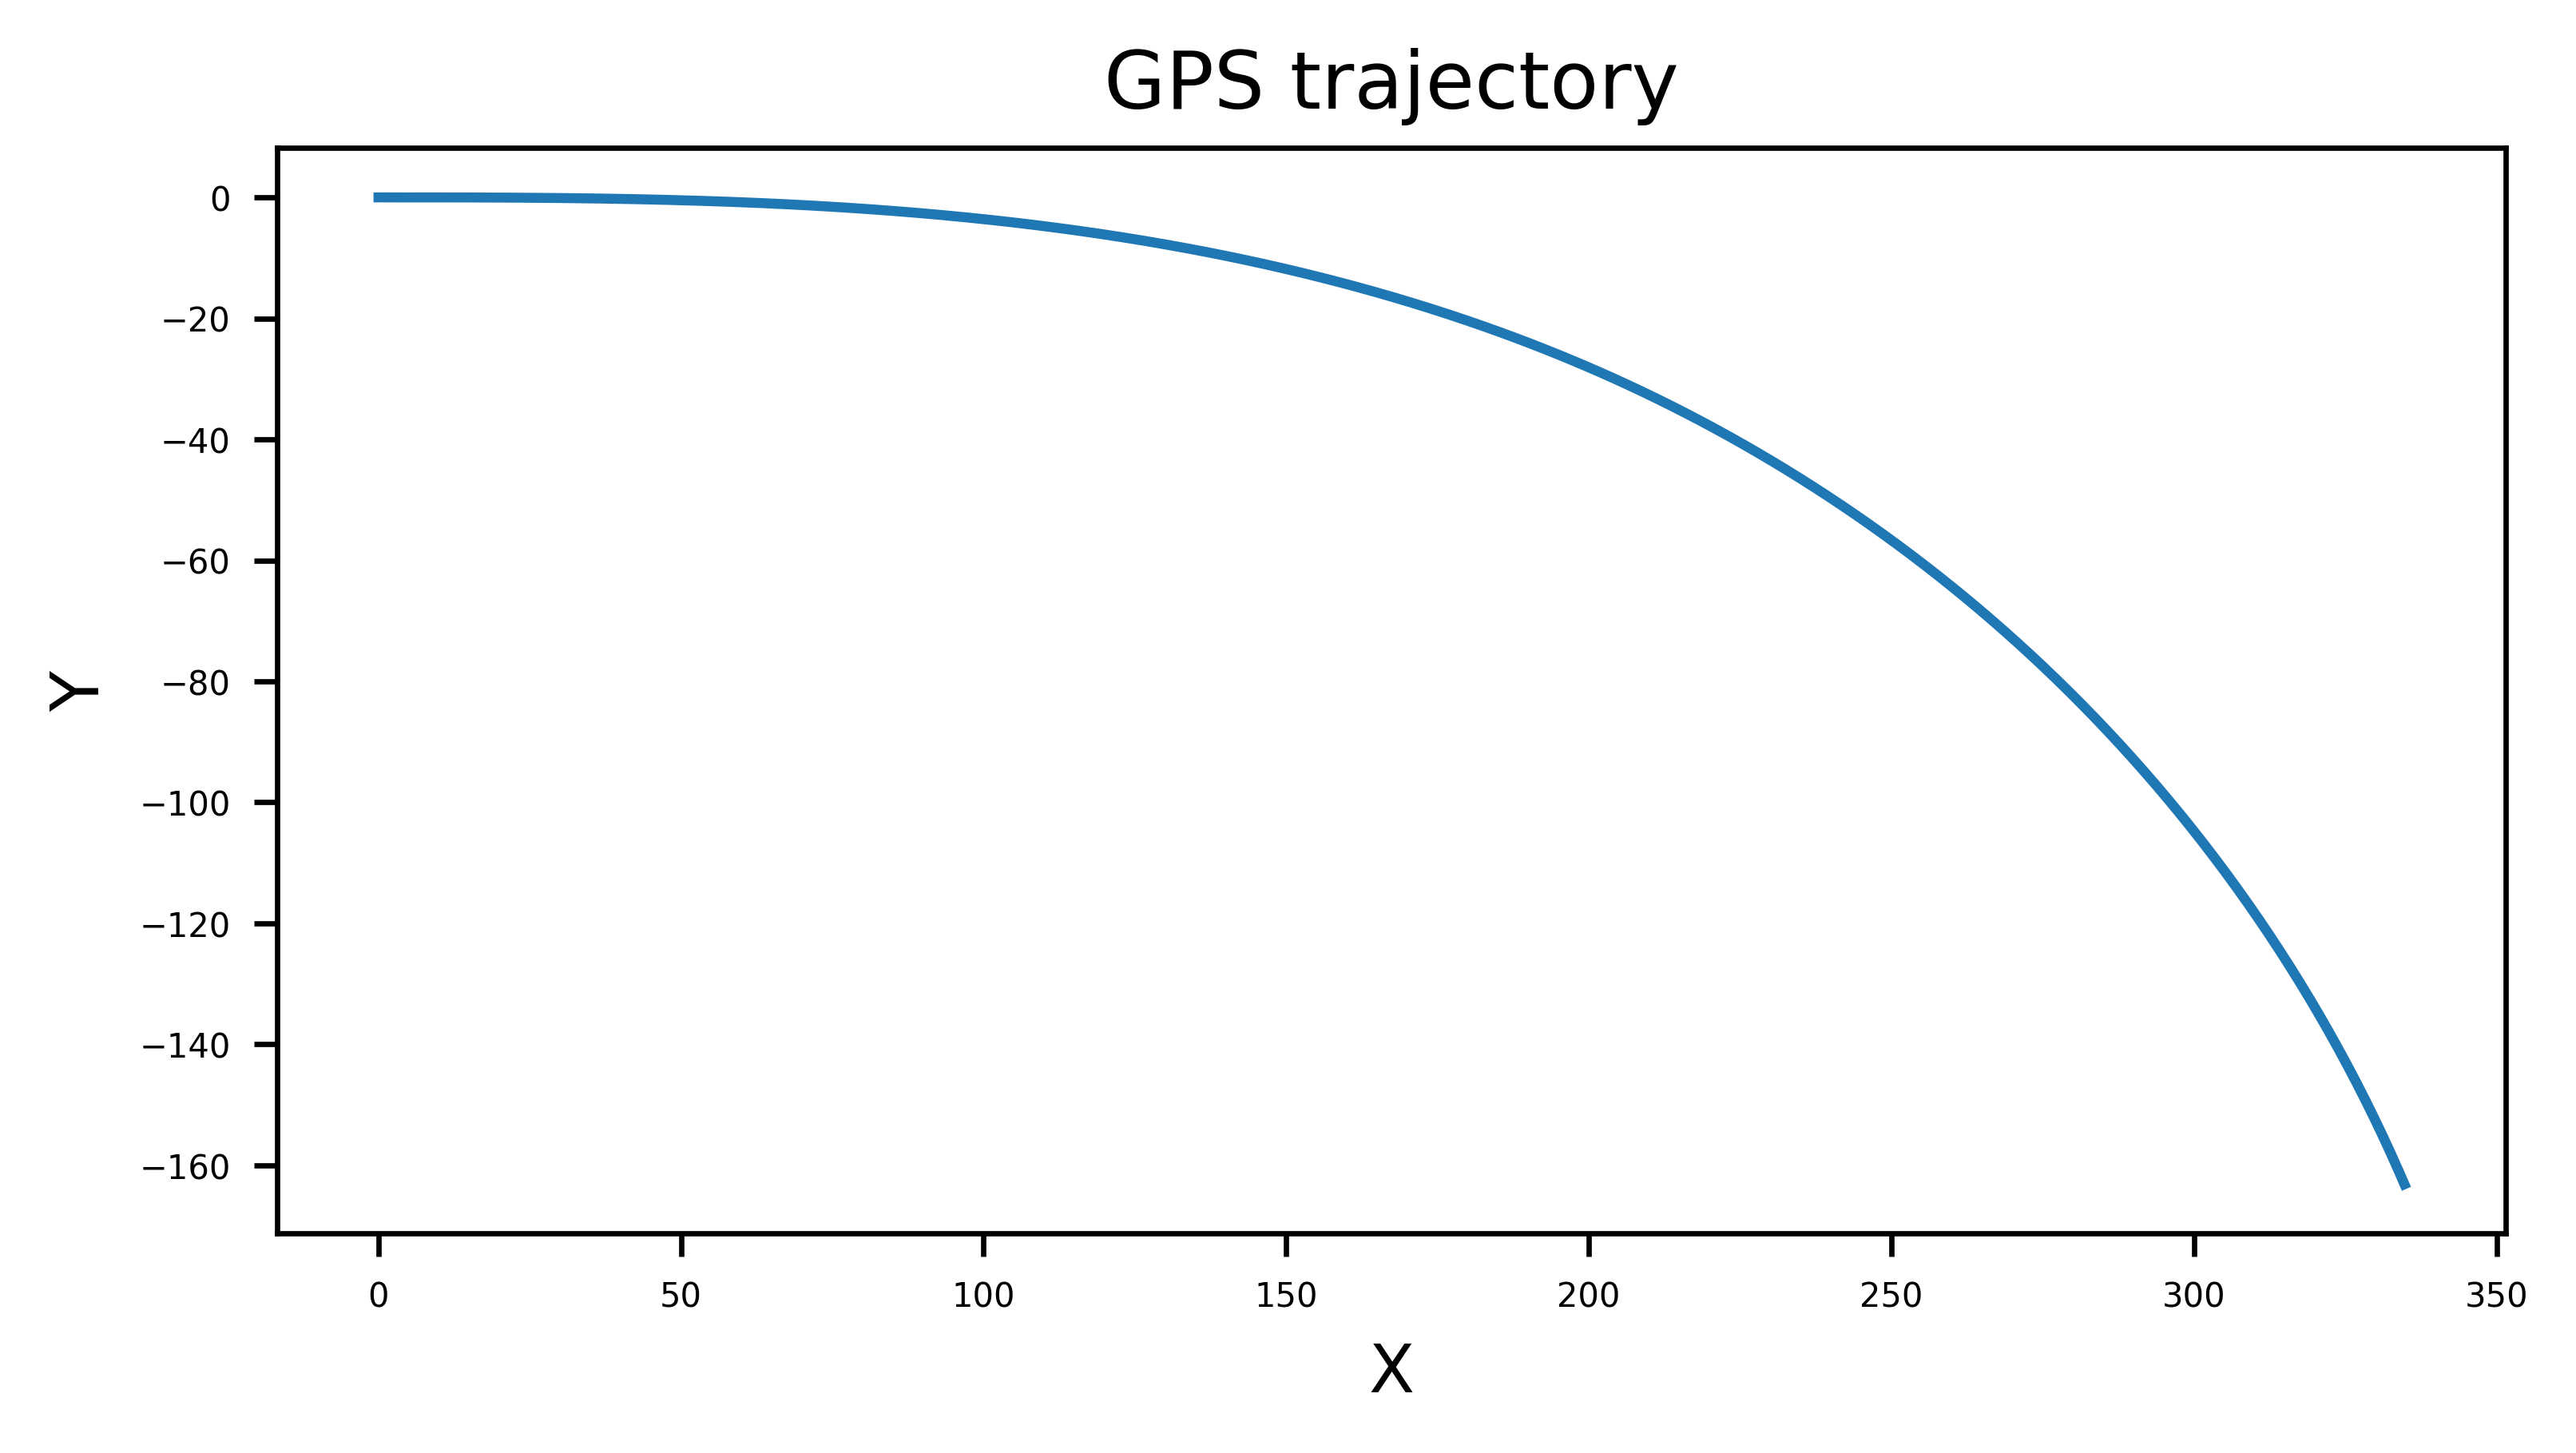

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600)
ax.set_title("GPS trajectory")
ax.plot(X, Y)
ax.set_ylabel("Y")
ax.set_xlabel("X");

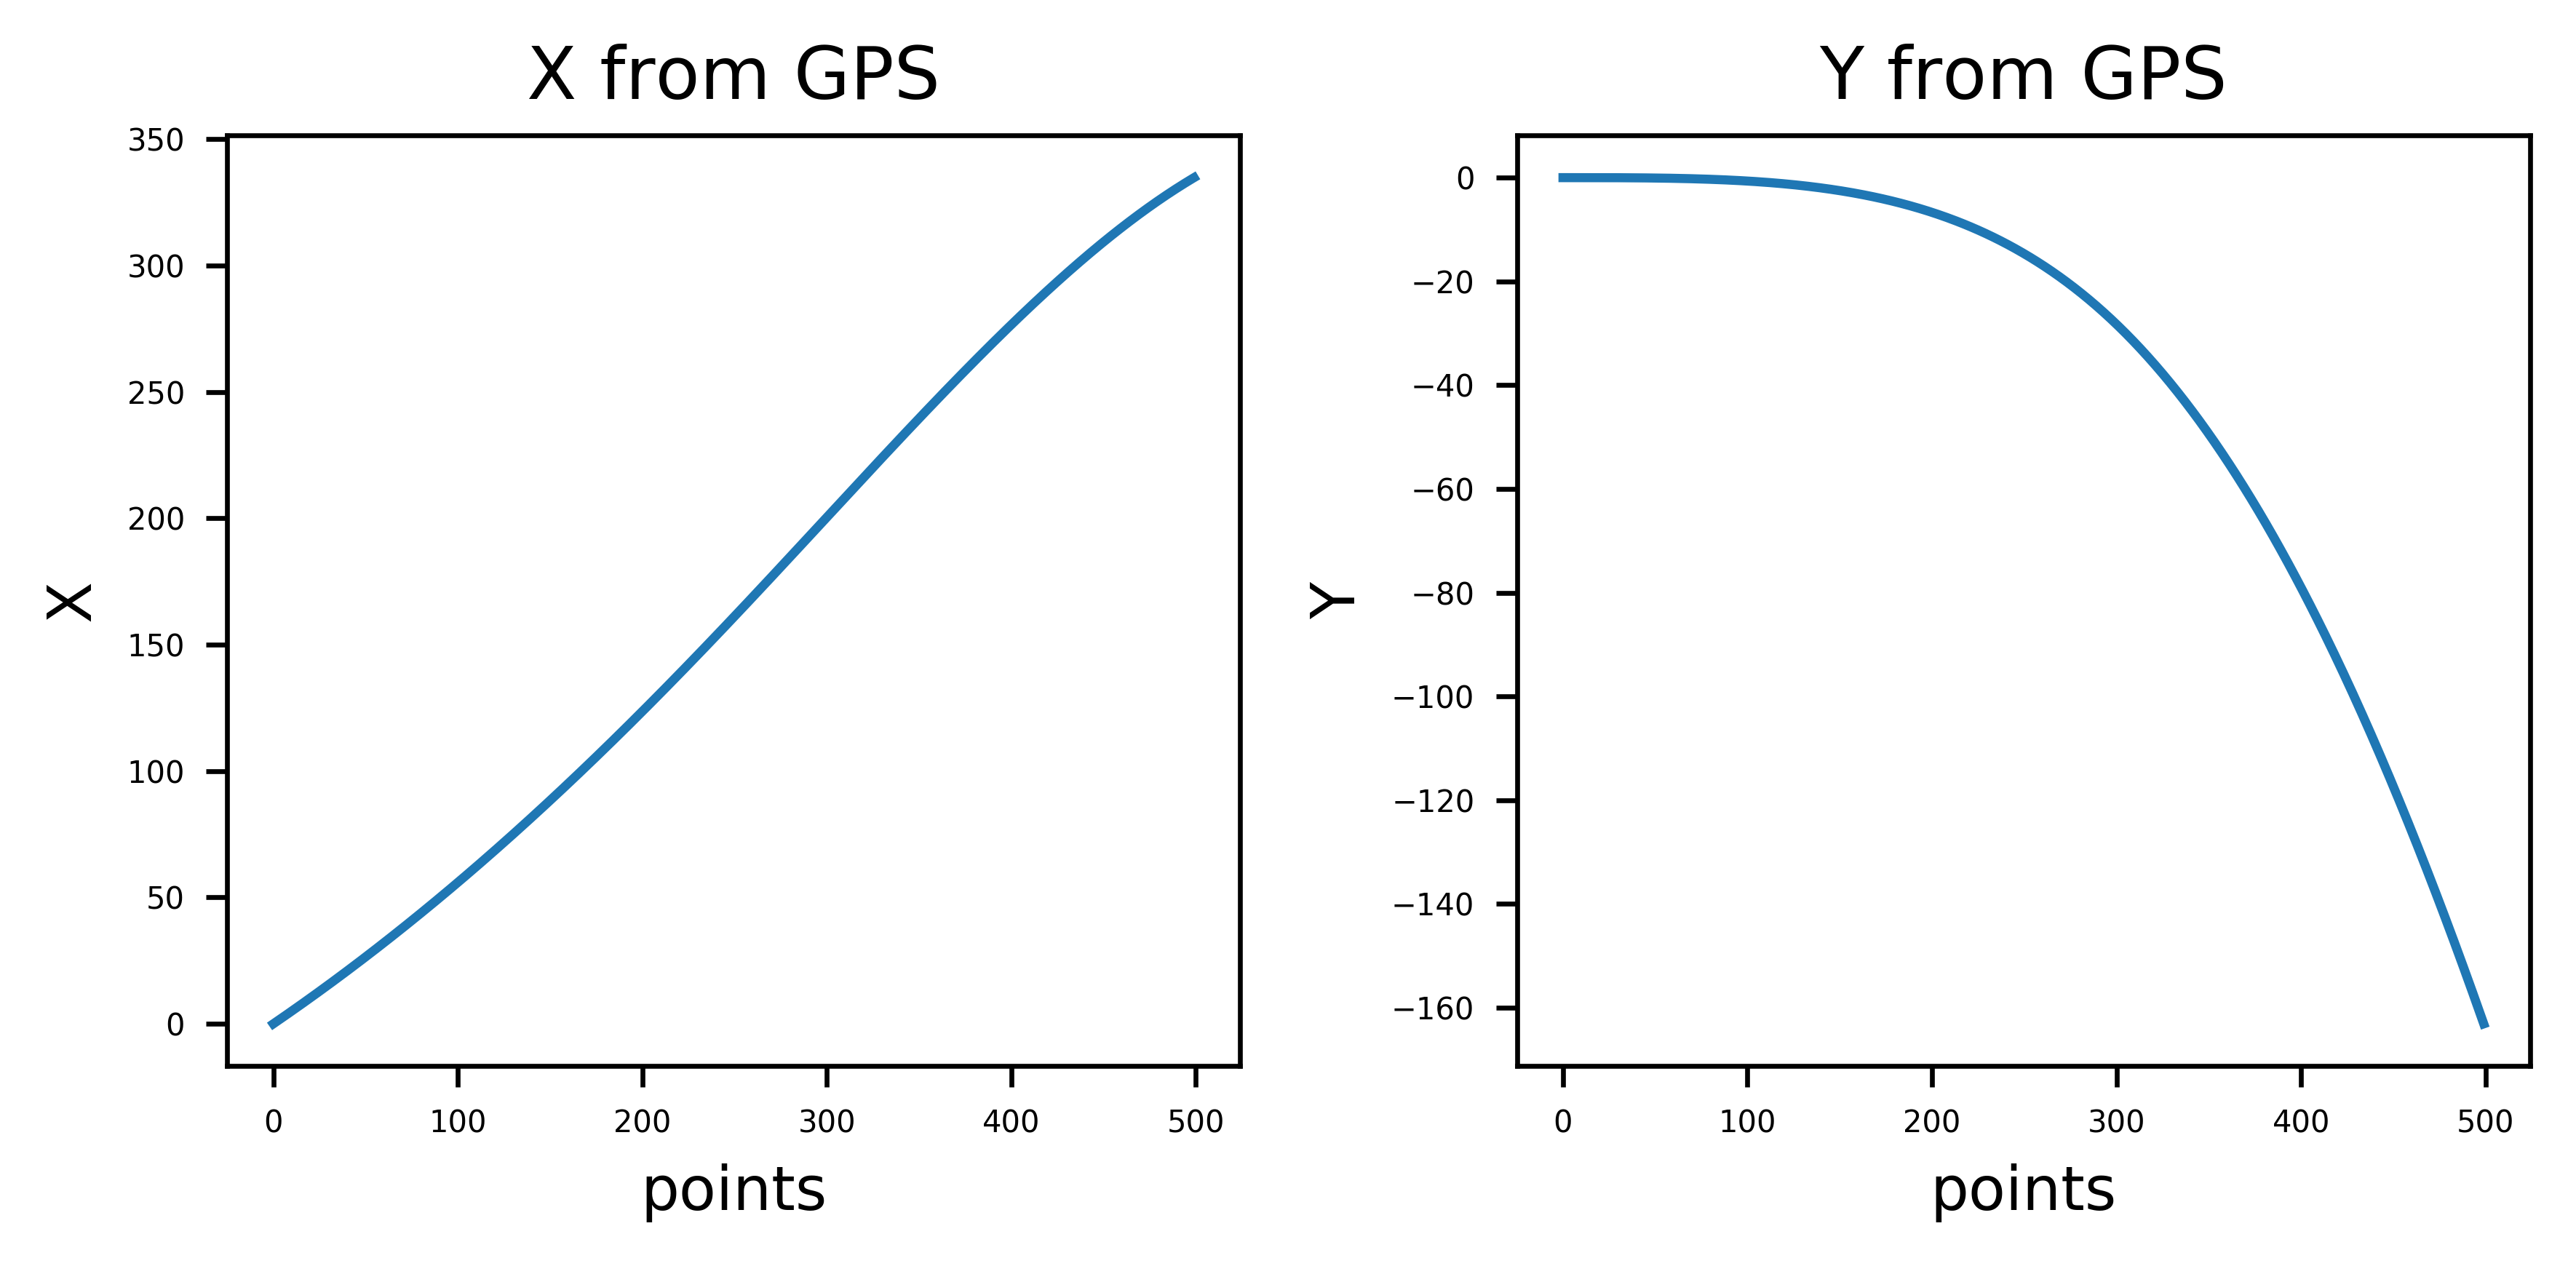

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=600)
ax[0].plot(X);ax[0].set_title("X from GPS");ax[0].set_ylabel("X");ax[0].set_xlabel("points");ax[1].plot(Y);ax[1].set_title("Y from GPS");ax[1].set_ylabel("Y");ax[1].set_xlabel("points");
plt.tight_layout();

## <center>Odometry data</center>

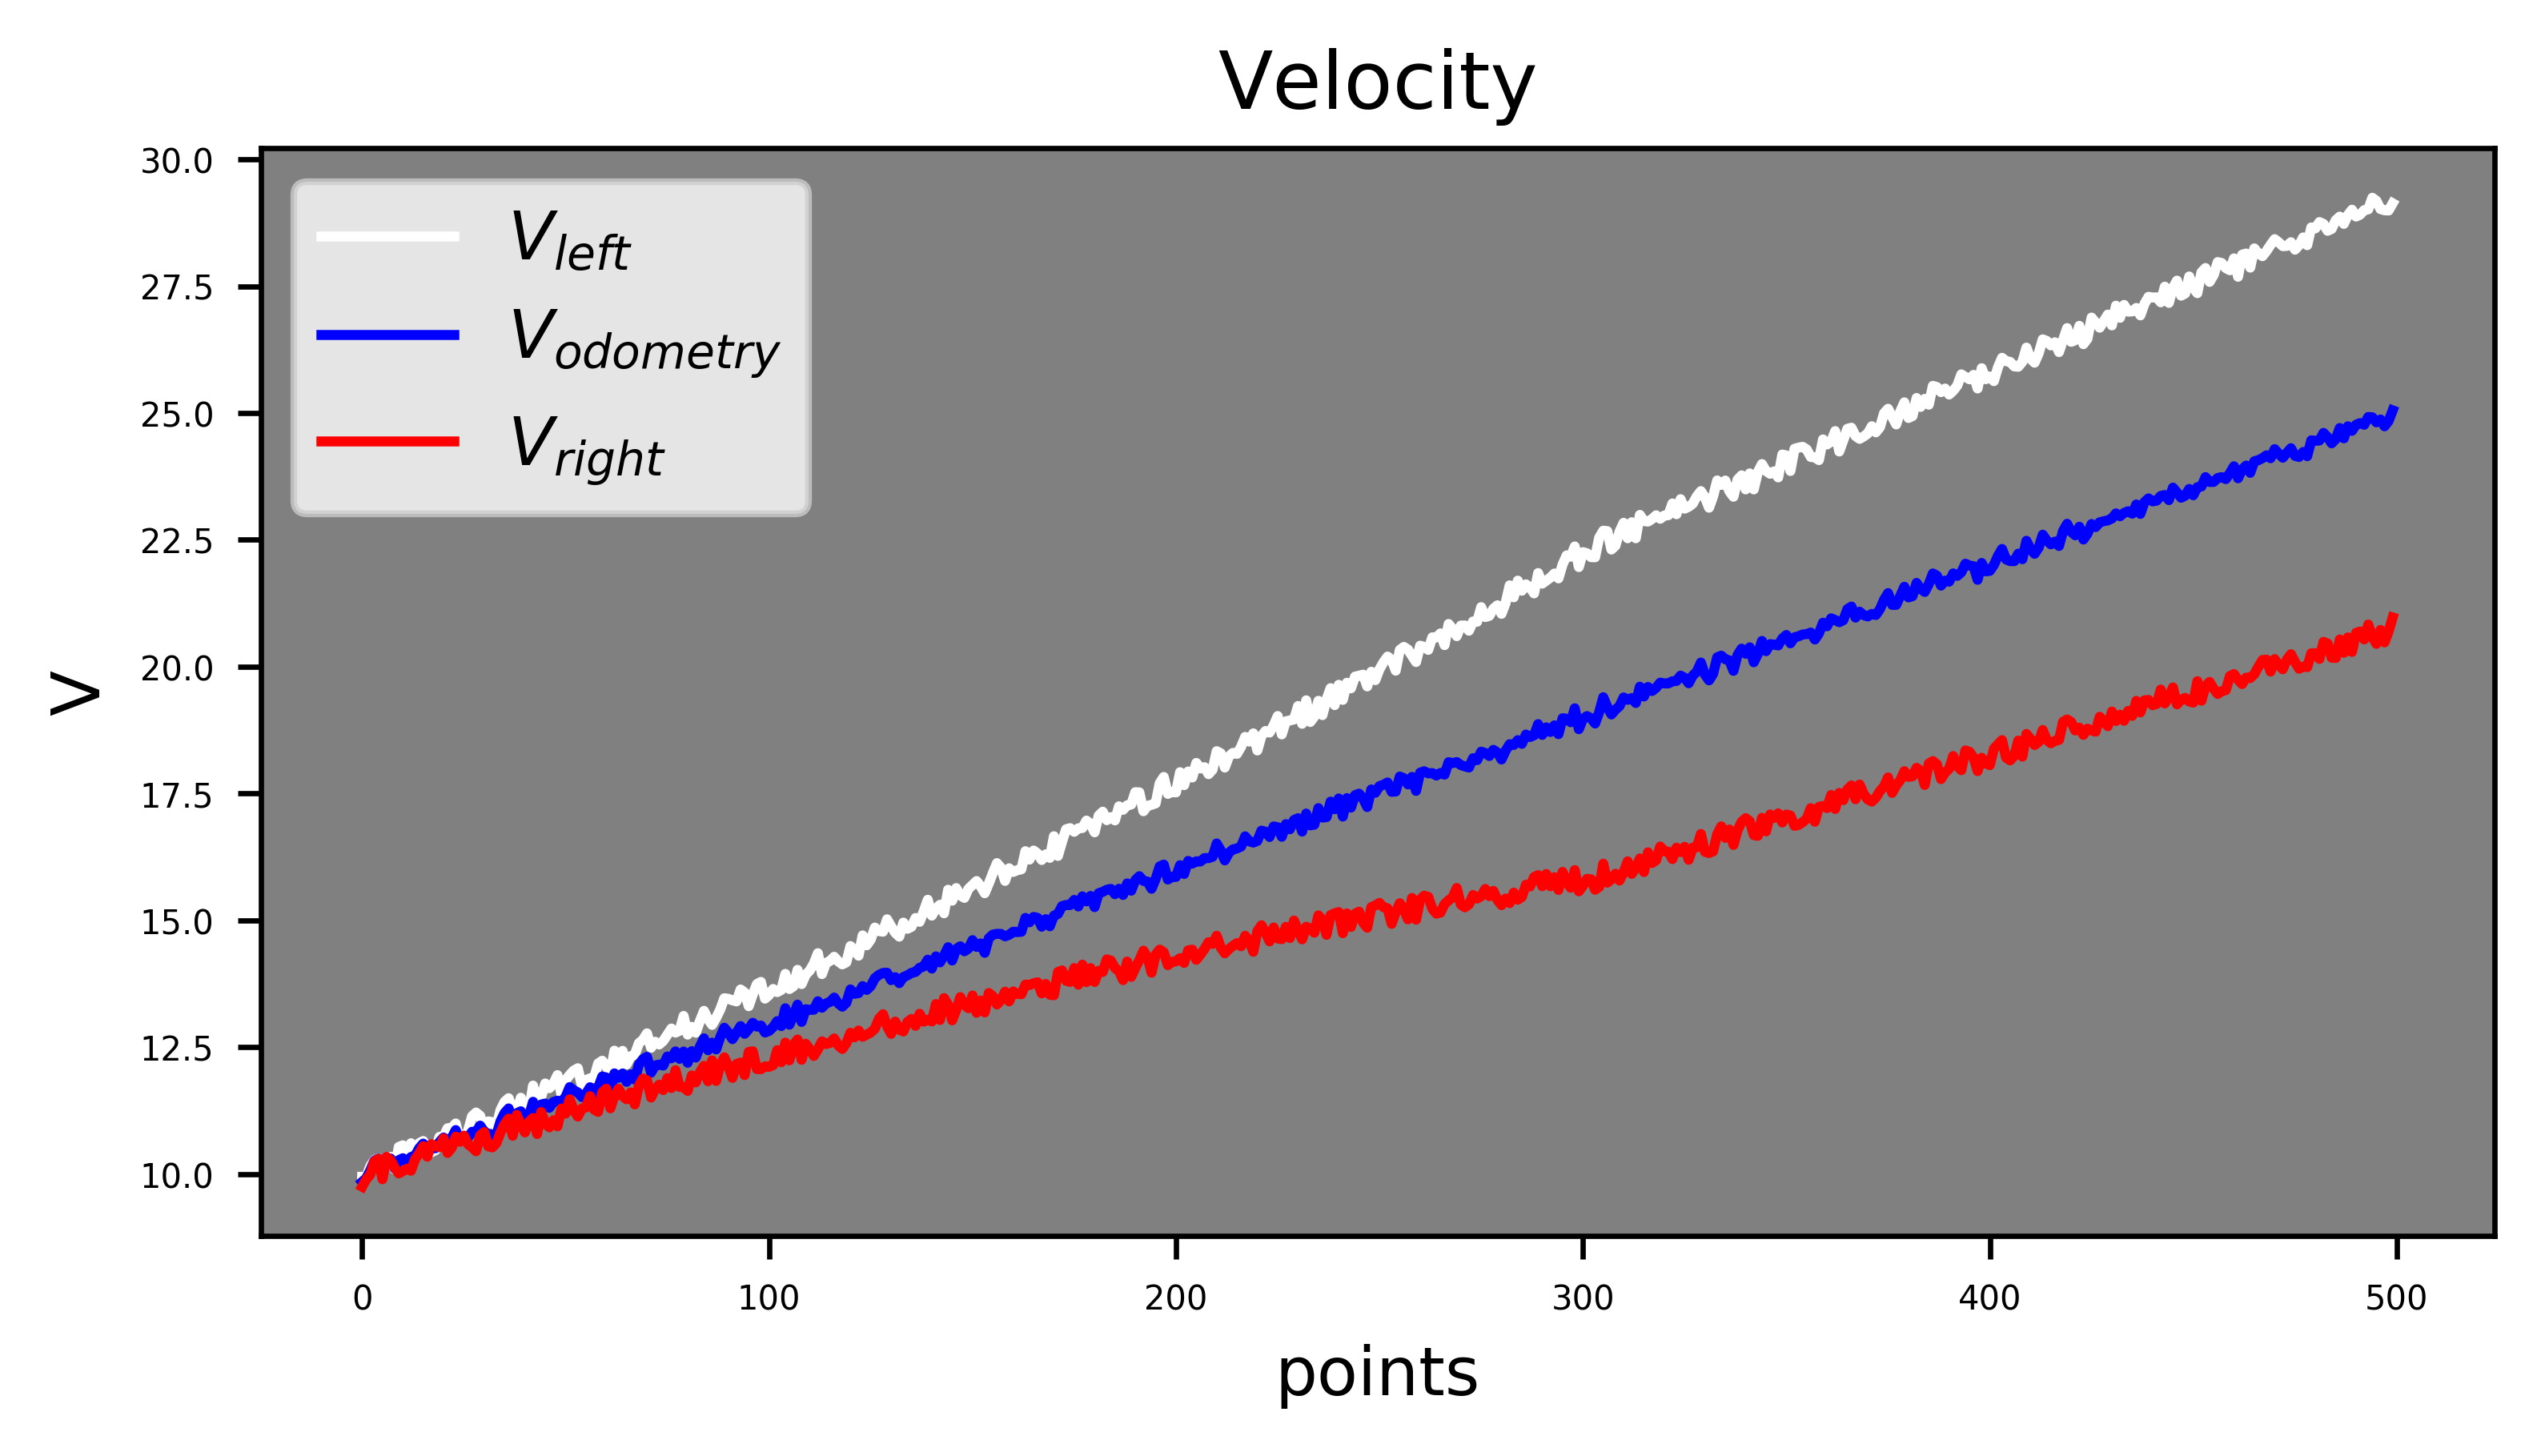

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600)
ax.patch.set_facecolor('grey');ax.set_title("Velocity");ax.plot(V_left,color='white',label=r'$V_{left}$');ax.plot(V_odom,color='blue',label=r"$V_{odometry}$");ax.plot(V_right,color='red',label=r'$V_{right}$');ax.set_xlabel("points");ax.set_ylabel("V");
ax.legend(loc='best');

# <center>Calculation of GPS velocity</center>

$$v_i = \frac{x_{i+1} - x_{i-1}}{2 t}$$

In [6]:
def velocity_from_traj(x, t):
    v = (np.roll(x, -1) - np.roll(x, 1)) / 2 / t
    v[-1] = v[-2]
    v[0] = v[1]
    return v

t = 0.05
V_x = velocity_from_traj(X, t)
V_y = velocity_from_traj(Y, t)
V_GPS = (V_x ** 2 + V_y ** 2) ** 0.5

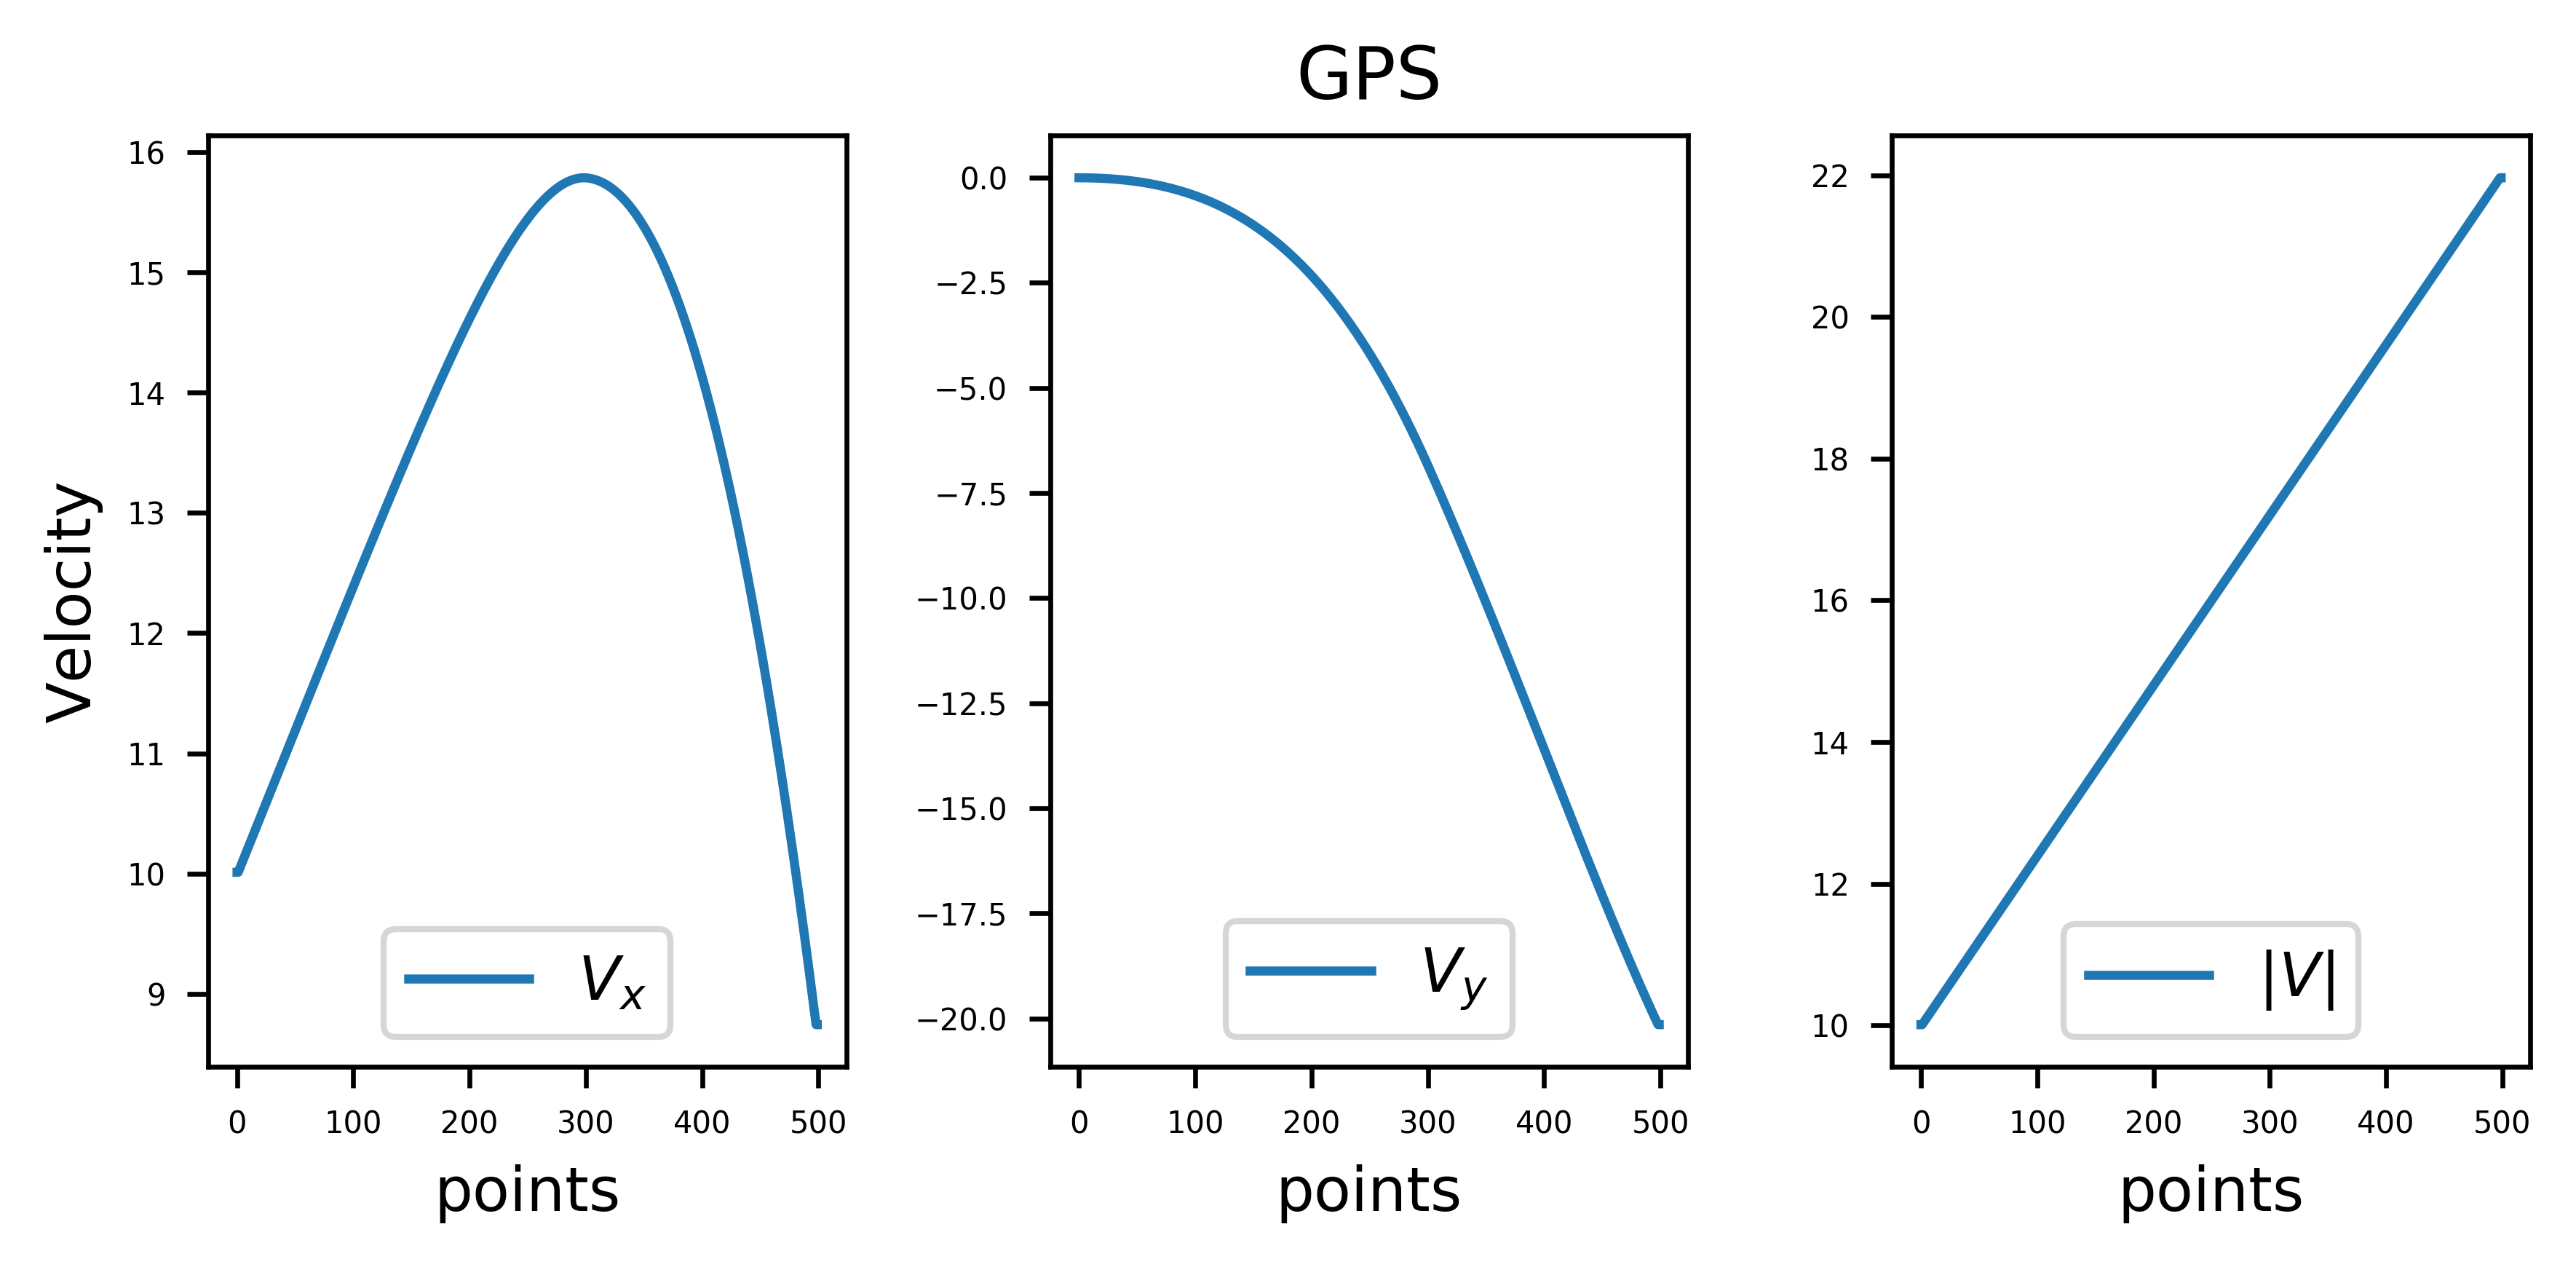

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(6, 3), dpi=600);
ax[0].plot(V_x,label='$V_x$');ax[1].set_title('GPS');ax[0].set_ylabel("Velocity");ax[1].plot(V_y,label="$V_y$");ax[2].plot(V_GPS,label=r"$\left|V\right|$");
for axe in ax: 
    axe.legend(loc='lower center');axe.set_xlabel("points");
fig.tight_layout();

# <center>Simple 1-dim linear regression</center>

In [8]:
def LR(y,x):
    N = len(y)
    β = inv(x.dot(x.transpose())).dot(x.dot(y.transpose()))
    return β
def RMS(y,x,β):
    return (np.sum((y-x.transpose().dot(β))**2)/ (len(y)-1)) ** 0.5

In [9]:
y = V_GPS
x = V_odom

In [10]:
β = LR(y,np.array([np.ones_like(x),x]))
print(β)
rms = RMS(y, np.array([np.ones_like(x),x]), β)
print(rms)

[ 2.01151947  0.79883512]
0.0851295301498


$$V_{GPS} = 2.01 + 0.8 \cdot V_{odometry}$$
$$RMS = 0.085$$

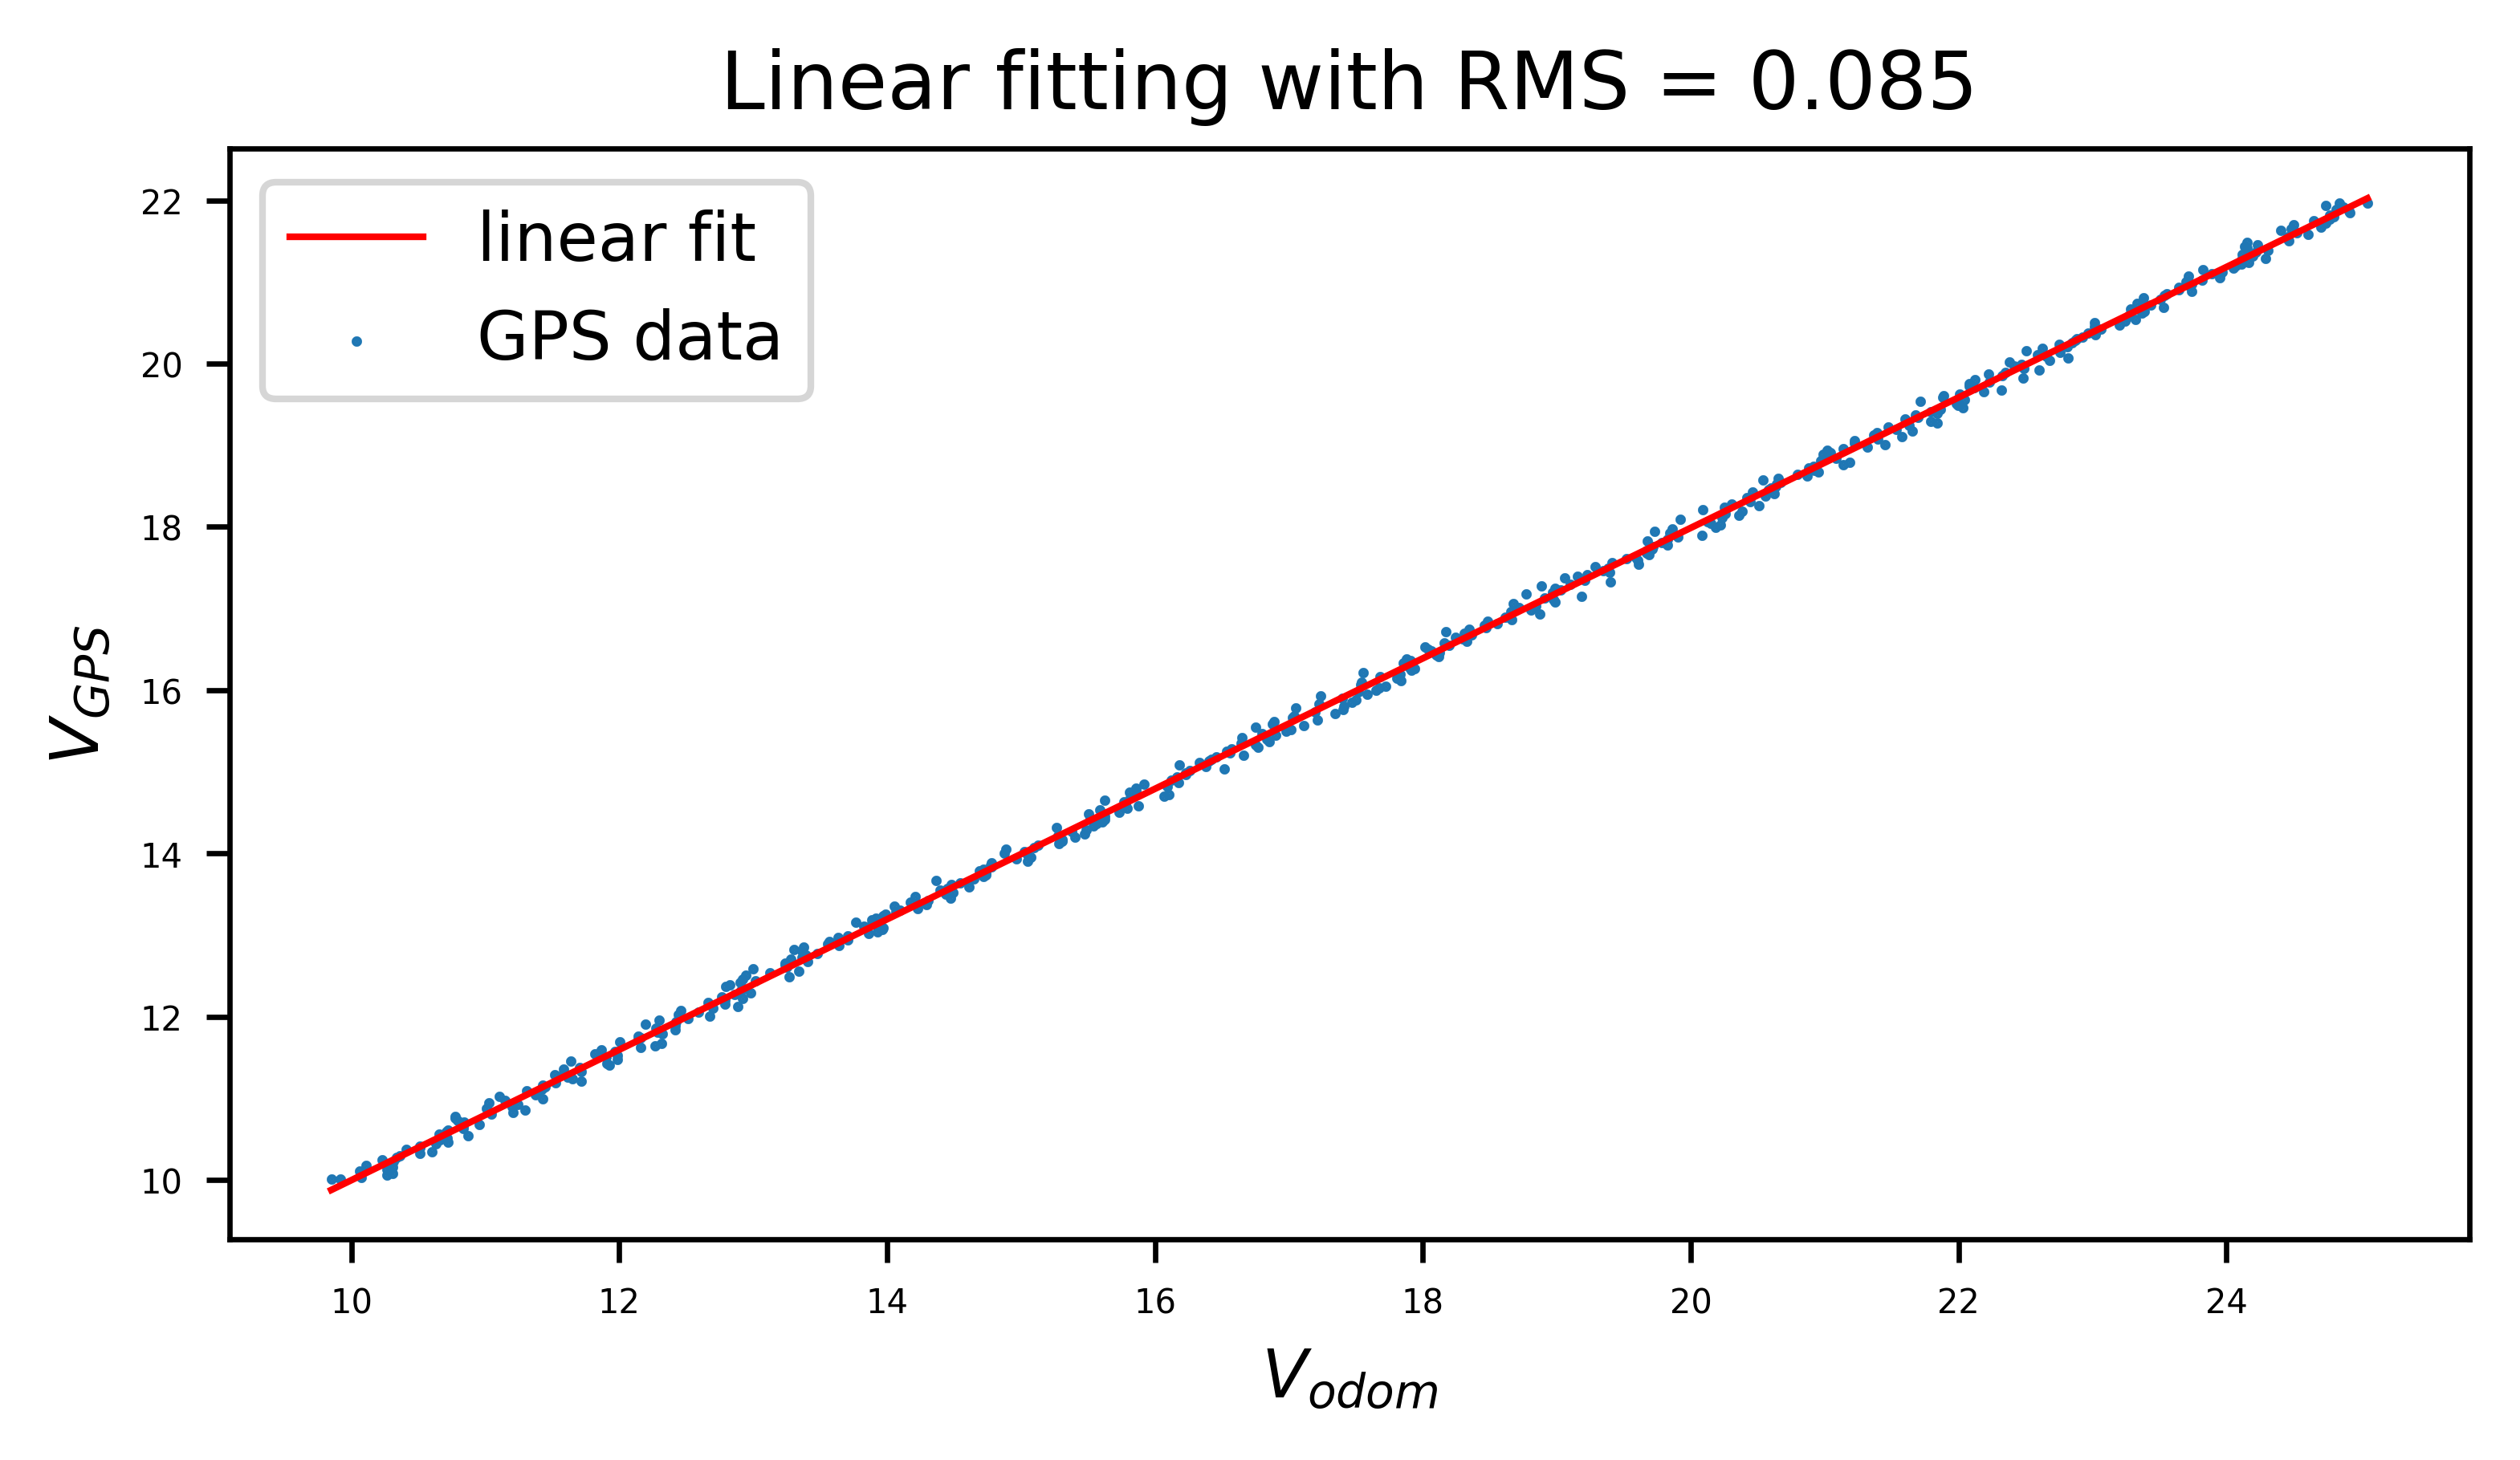

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600);ax.scatter(x, y, s=0.3,label='GPS data');x_line = x;y_line = np.array([np.ones_like(x),x]).transpose().dot(β);ax.plot(x_line, y_line, linewidth=1, color="r",label='linear fit');ax.legend(loc='best');ax.set_xlabel("$V_{odom}$");ax.set_ylabel("$V_{GPS}$");
ax.set_title("Linear fitting with RMS = %.3f" % rms);

# Let's provide a little bit of noise to the GPS data and try to recover $C_0$, $C_1$ again

## <center>Noisify data</center>

In [12]:
sigma_n_2 = 3 ** 2
Xn = X + np.random.normal(0, sigma_n_2 ** 0.5, X.shape[0])
Yn = Y + np.random.normal(0, sigma_n_2 ** 0.5, Y.shape[0])

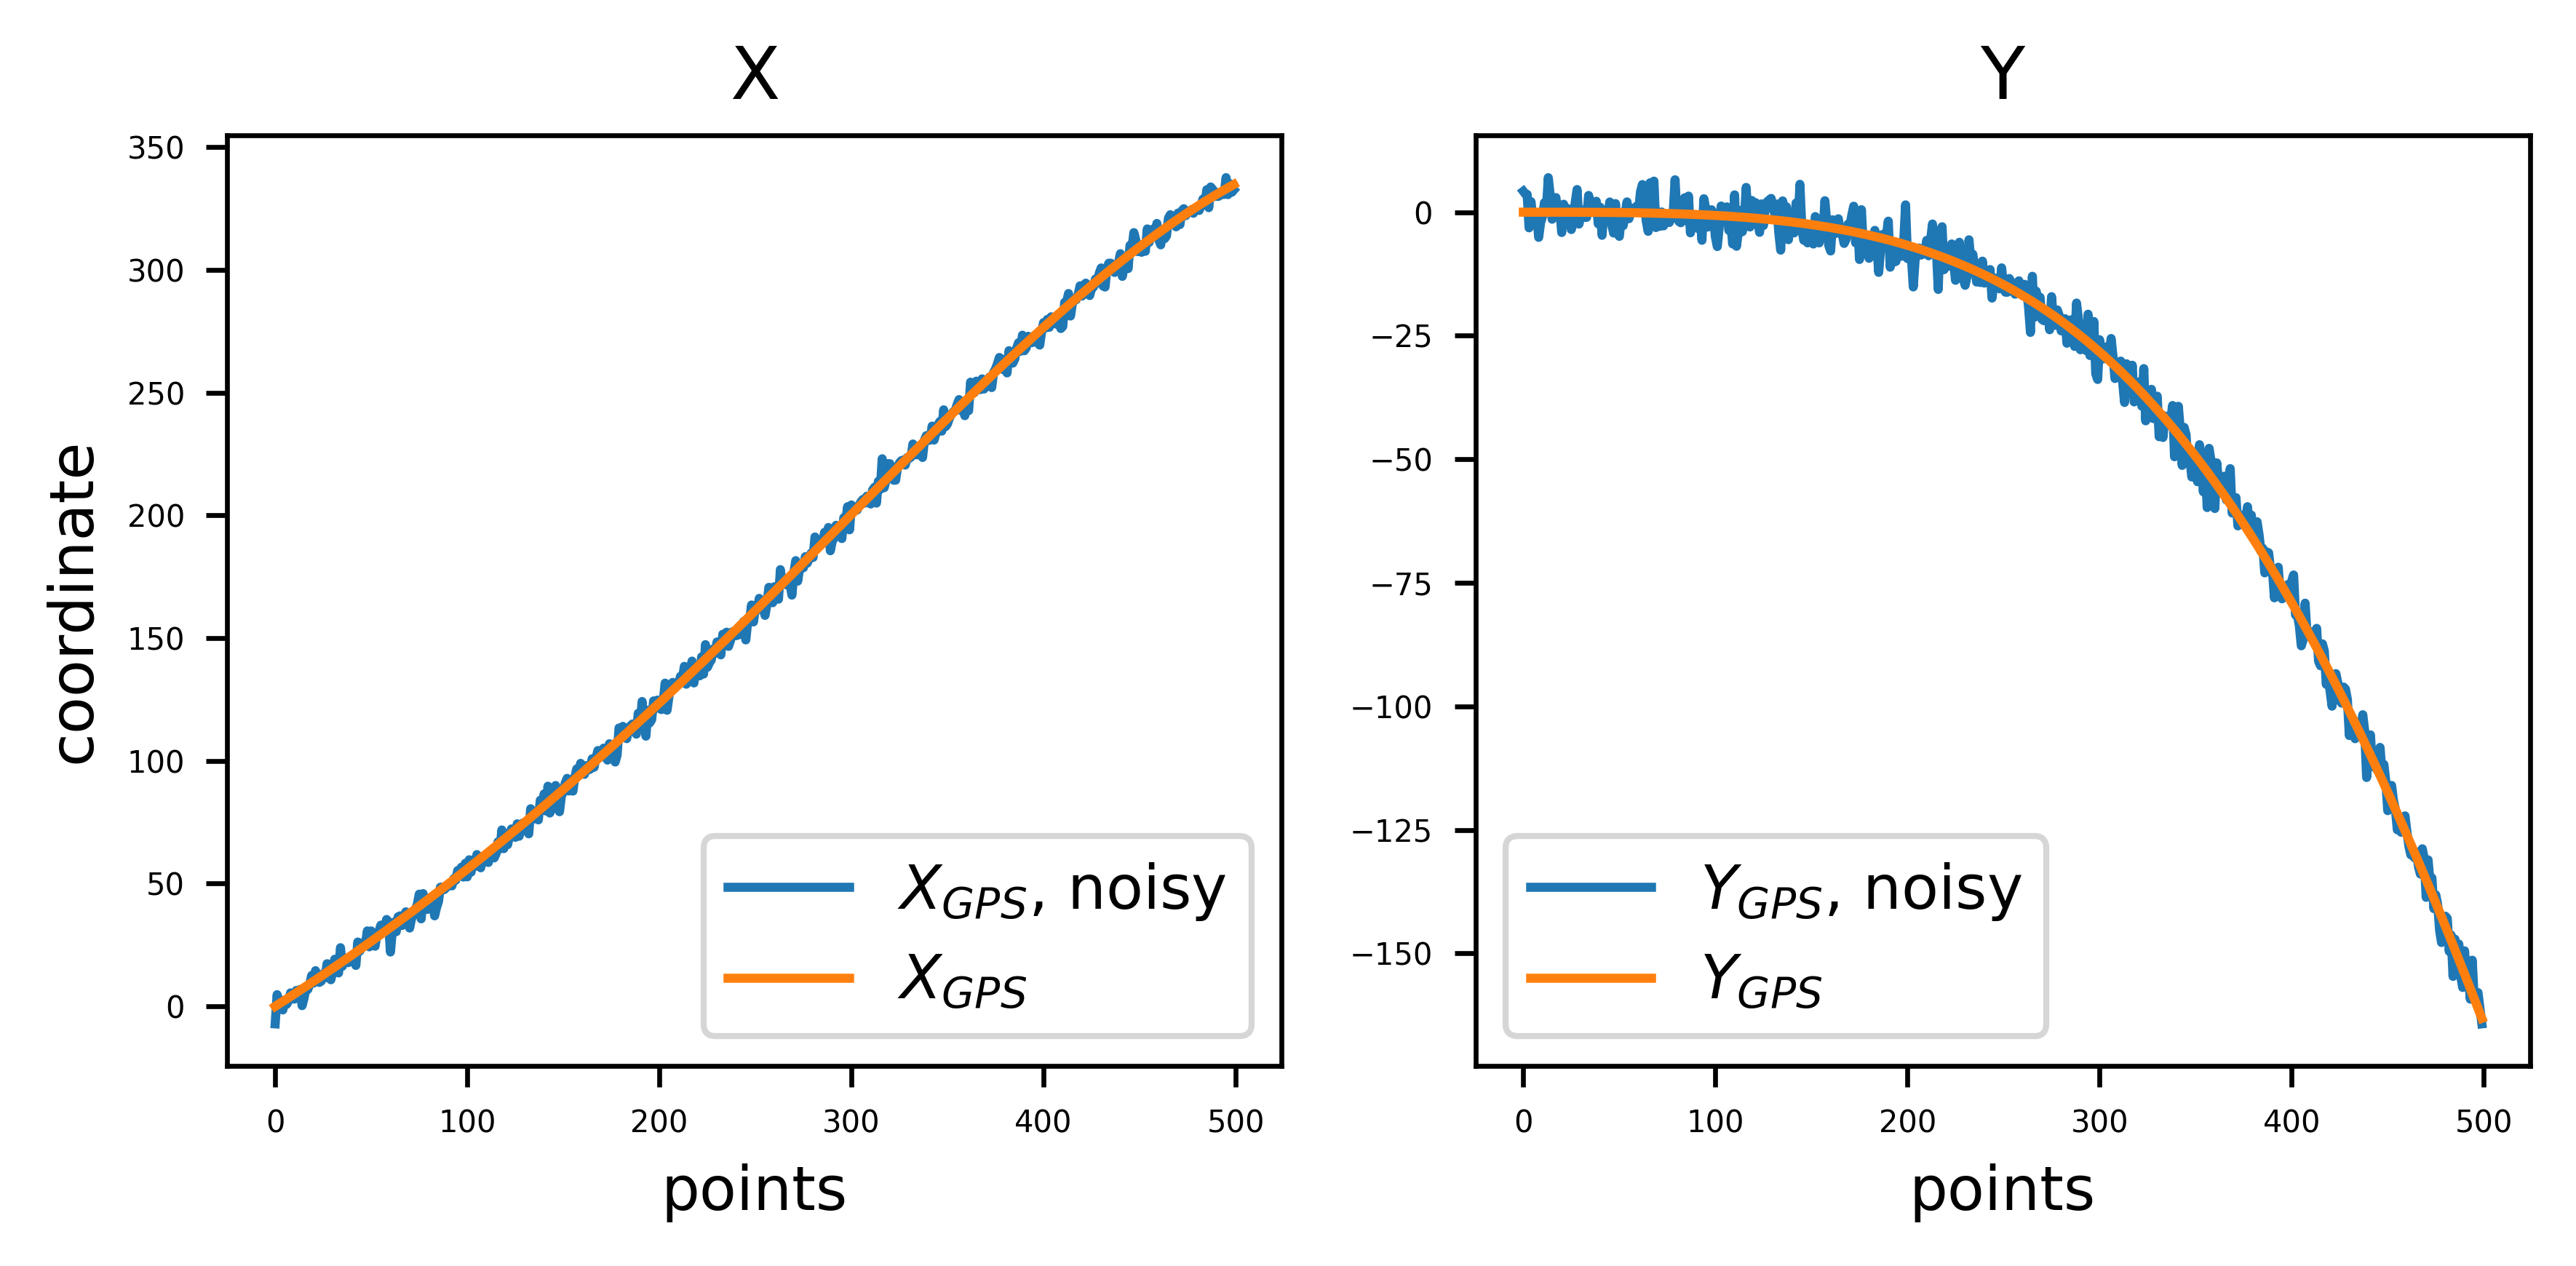

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=600);ax[0].plot(Xn,label=r'$X_{GPS}$, noisy');ax[0].plot(X, label=r'$X_{GPS}$');ax[0].set_title("X");ax[0].set_ylabel("coordinate");ax[0].legend(loc='lower right');ax[1].plot(Yn,label=r'$Y_{GPS}$, noisy');ax[1].plot(Y, label=r'$Y_{GPS}$');ax[1].set_title("Y");ax[1].legend(loc='lower left');
for axe in ax:
    axe.set_xlabel("points")
plt.tight_layout();

## <center>Use Kalman filter to reduce introduced noise</center>

In [14]:
def kalman(X_0, P_0, z, T, H, R, Q):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros((len(z),*(H.transpose().shape)))
    XF= np.zeros_like(X)
    Xp= np.zeros_like(X)
    T6 = np.linalg.matrix_power(T,6)
    for i, _ in enumerate(z):
        #Prediction
        Xp[i] = X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
        tmp2 = H.transpose().dot(tmp1)
        K[i] = P[i].dot(tmp2)
        X[i] = X[i] + K[i].dot(z[i] - H.dot(X[i]))
        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(H)).dot(P[i])
    return X, K, P, Xp

In [16]:
zx = Xn
zy = Yn

z = np.zeros((Xn.shape[0], 2, 1))

t = 0.05
sigma_a_2 = 1
X_0 = np.array([[zx[1]],
                [(zx[1]-zx[0])/t],
                [zy[1]],
                [(zy[1]-zy[0])/t]])

Φ = np.array([[1, t, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, t],
               [0, 0, 0, 1]])

G = np.array([[t*t/2, 0],
              [t    , 0],
              [0, t*t/2],
              [0,     t]])

Q = G.dot(G.transpose())*sigma_a_2*5

H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

P_0 = np.eye(4)*10**4

R = np.eye(2)*sigma_n_2
z[:,0,0] = zx
z[:,1,0] = zy

## <center>Forward Kalman...</center>

In [17]:
Xk, _, P, _ = kalman(X_0, P_0, z[2:], Φ, H, R, Q)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(6,3),dpi=600)
ax[0][0].set_title('Kalman filter', fontsize = 10);ax[0][0].plot(z[2:,0,0],'g', label = '$z_x$', linewidth = 0.5 );ax[0][0].plot(X[2:],'b', label = '$X_{true}$', linewidth = 1 );ax[0][0].plot(Xk[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 );ax[0][0].set_ylabel('magnitude');ax[0][0].legend(loc='lower right');
ax[0][1].set_title('Kalman filter', fontsize = 10);ax[0][1].plot(z[2:,1,0],'g', label = '$z_y$', linewidth = 0.5 );ax[0][1].plot(Y[2:],'b', label = '$Y_{true}$', linewidth = 1 );ax[0][1].plot(Xk[:,2].transpose()[0],'r', label = '$Y_{kalman}$', linewidth = 1 );ax[0][1].legend(loc='lower left');
ax[1][0].plot(z[2:,0,0],'g', label = '$z_x$', linewidth = 0.5 );ax[1][0].plot(X[2:],'b', label = '$X_{true}$', linewidth = 1 );ax[1][0].plot(Xk[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 );ax[1][0].set_ylabel('magnitude');ax[1][0].set_xlim([0,100]);ax[1][0].set_ylim([0,60]);ax[1][0].set_xlabel('points');
ax[1][1].plot(z[2:,1,0],'g', label = '$z_y$', linewidth = 0.5 );ax[1][1].plot(Y[2:],'b', label = '$Y_{true}$', linewidth = 1 );ax[1][1].plot(Xk[:,2].transpose()[0],'r', label = '$Y_{kalman}$', linewidth = 1 );ax[1][1].set_xlim([200,300]);ax[1][1].set_ylim([-5,-30]);ax[1][1].set_xlabel('points');

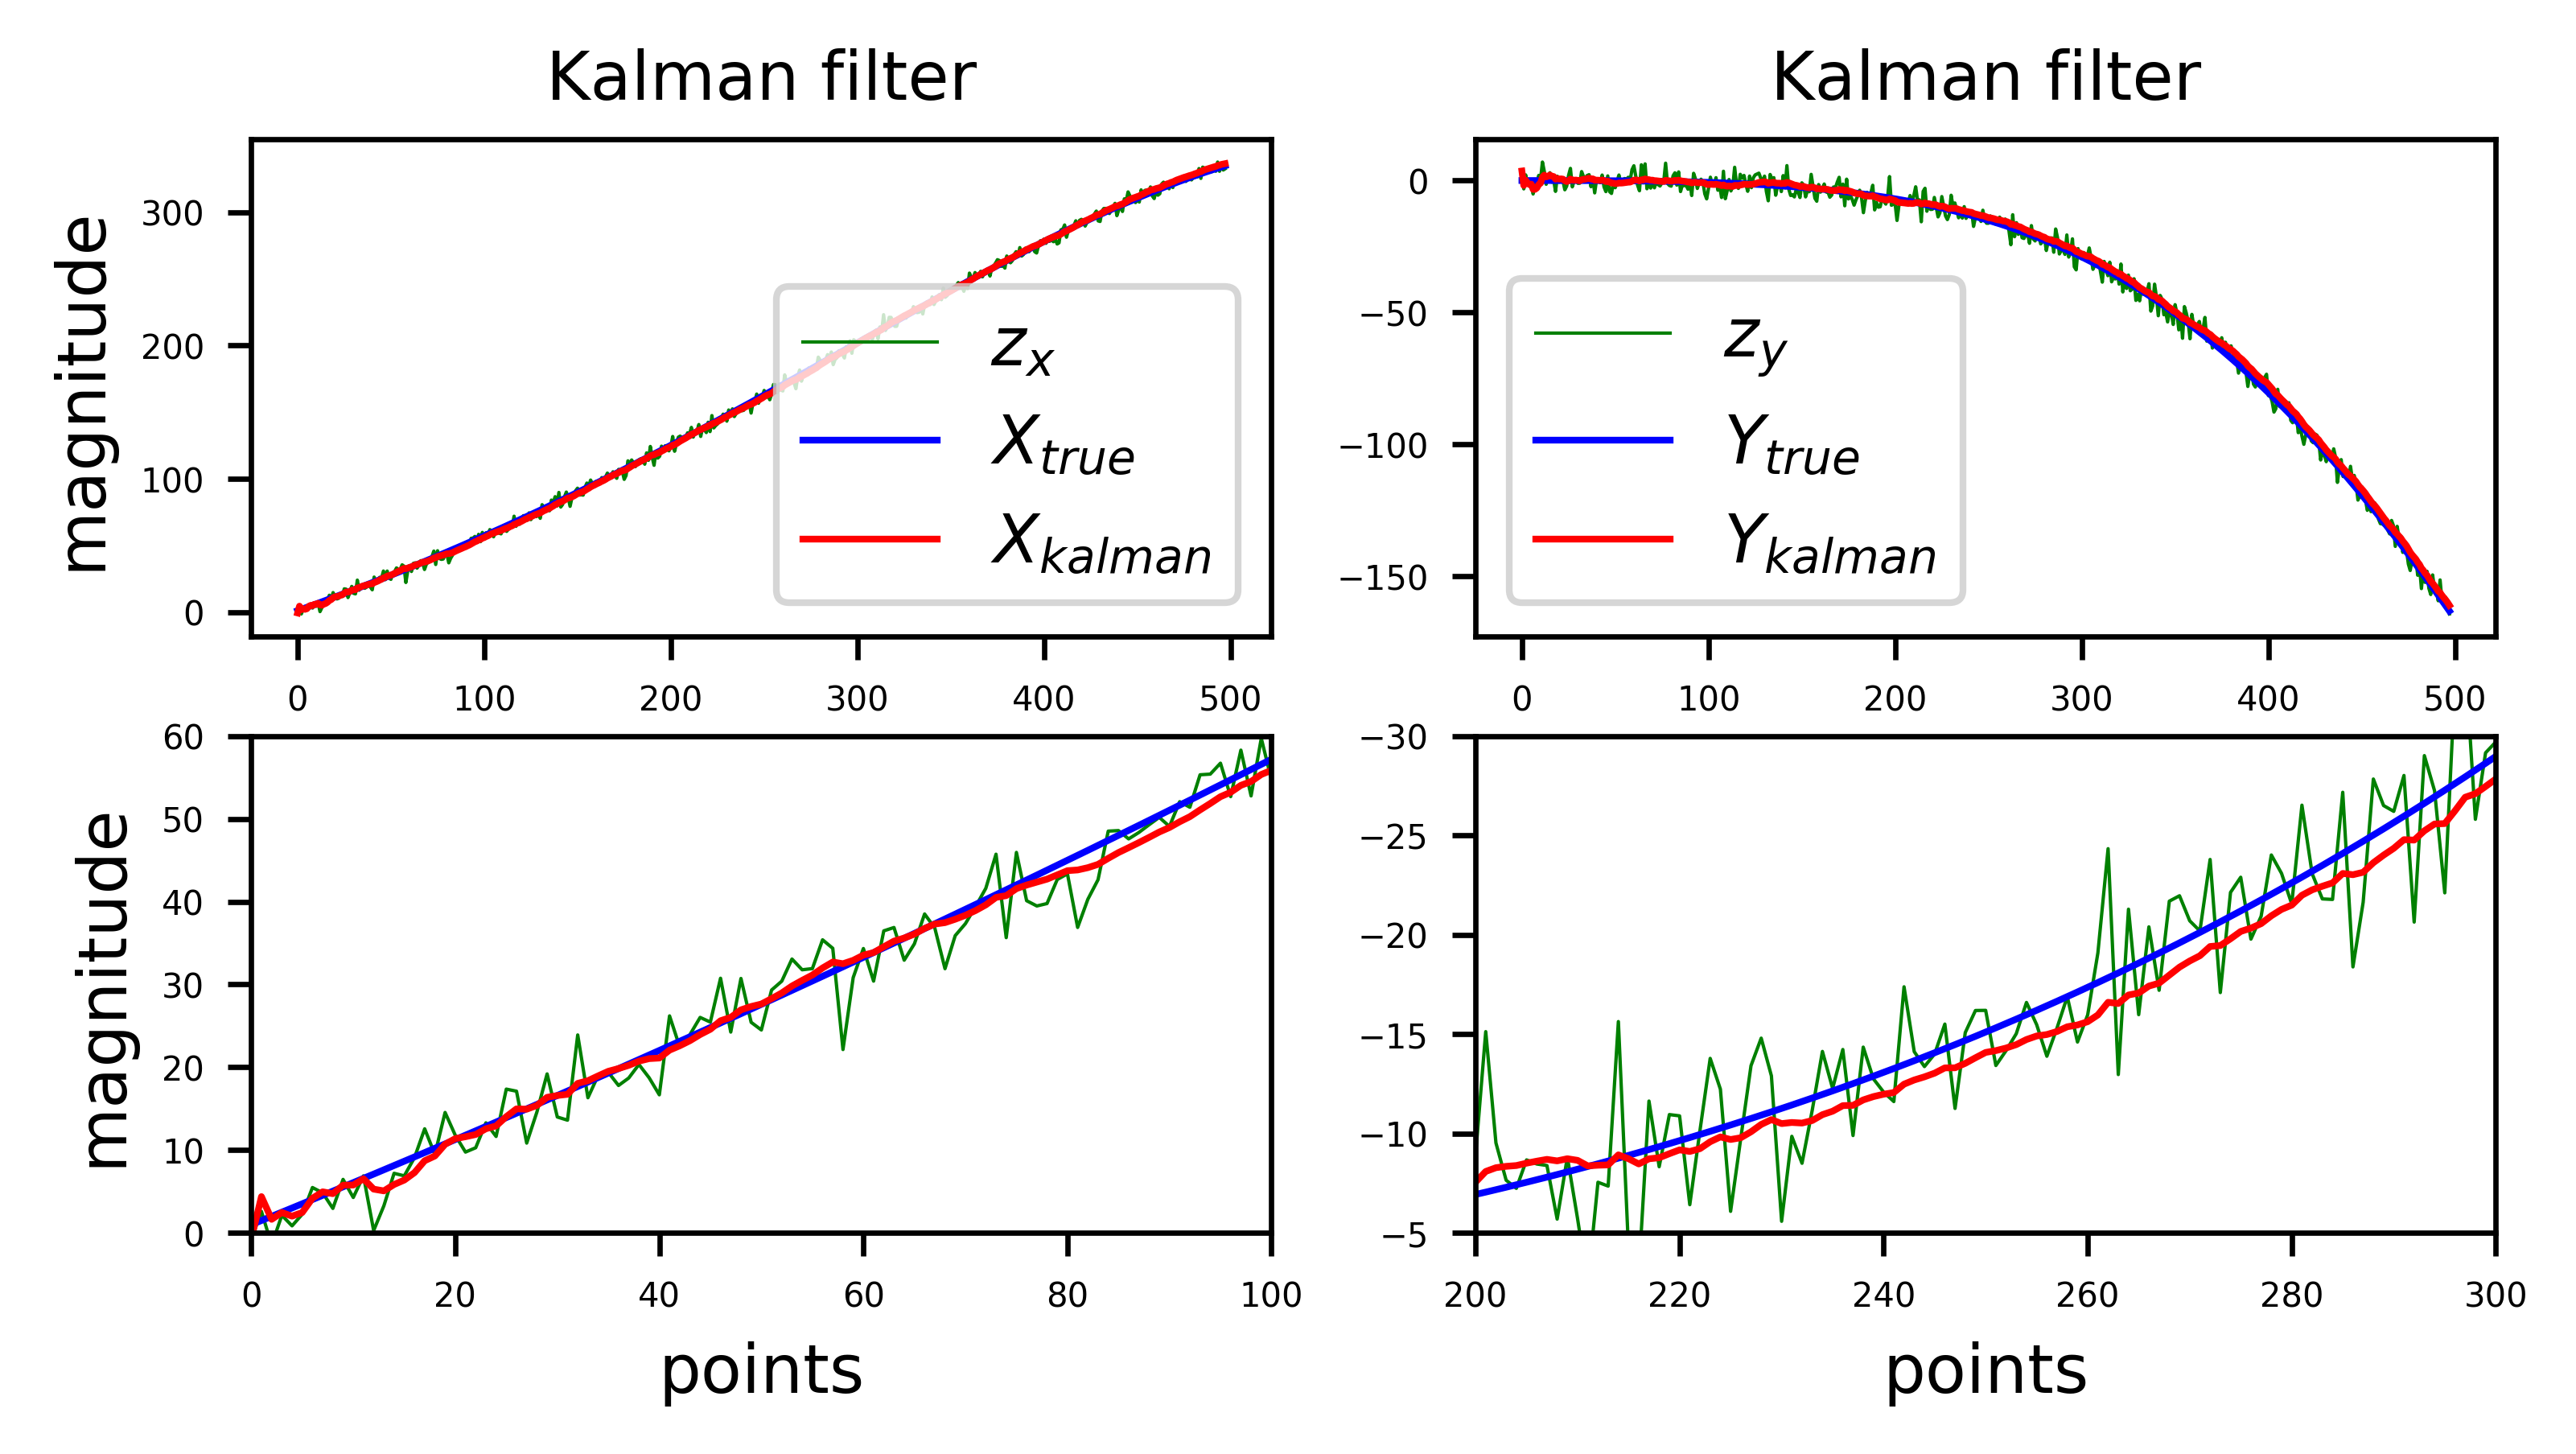

## <center>Huge oscillations at first points $\Rightarrow$ need for backward smoothing</center>

In [22]:
def backward_smoothing(X, P, Q, T):
    Xs = np.zeros_like(X)
    Pr = np.zeros_like(P)
    Ps = np.zeros_like(P)
    A = np.zeros_like(P)
    N = X.shape[0]
    for i in range(N-1, -1, -1):
        Pr[i] = T.dot(P[i]).dot(T.transpose()) + Q
        A[i] = P[i].dot(T.transpose()).dot(inv(Pr[i]))
        Xs[i] = X[i] + A[i].dot((Xs[i+1] if i < N-1 else X[N-1]) - T.dot(X[i]))
        Ps[i] = P[i] + A[i].dot(Pr[i] - P[i]).dot(A[i].transpose())
    return Xs, A, Ps

In [23]:
Xs, _, _ = backward_smoothing(Xk, P, Q, Φ)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(6,3),dpi=600)
ax[0].set_title('Kalman filter ', fontsize = 10);ax[0].plot(z[2:,0,0],'g', label = '$z_x$', linewidth = 0.5 );ax[0].plot(X[2:],'b', label = '$X_{true}$', linewidth = 1 );ax[0].plot(Xs[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 );ax[0].set_ylabel('magnitude');ax[0].set_xlim([0,100]);ax[0].set_ylim([0,60]);
ax[1].set_title('Kalman filter', fontsize = 10);ax[1].plot(z[2:,1,0],'g', label = '$z_y$', linewidth = 0.5 );ax[1].plot(Y[2:],'b', label = '$Y_{true}$', linewidth = 1 );ax[1].plot(Xs[:,2].transpose()[0],'r', label = '$Y_{kalman}$', linewidth = 1 );ax[1].set_xlim([200,300]);ax[1].set_ylim([-5,-30]);
for axe in ax:
    axe.set_xlabel('points')
    axe.legend(loc='lower right');

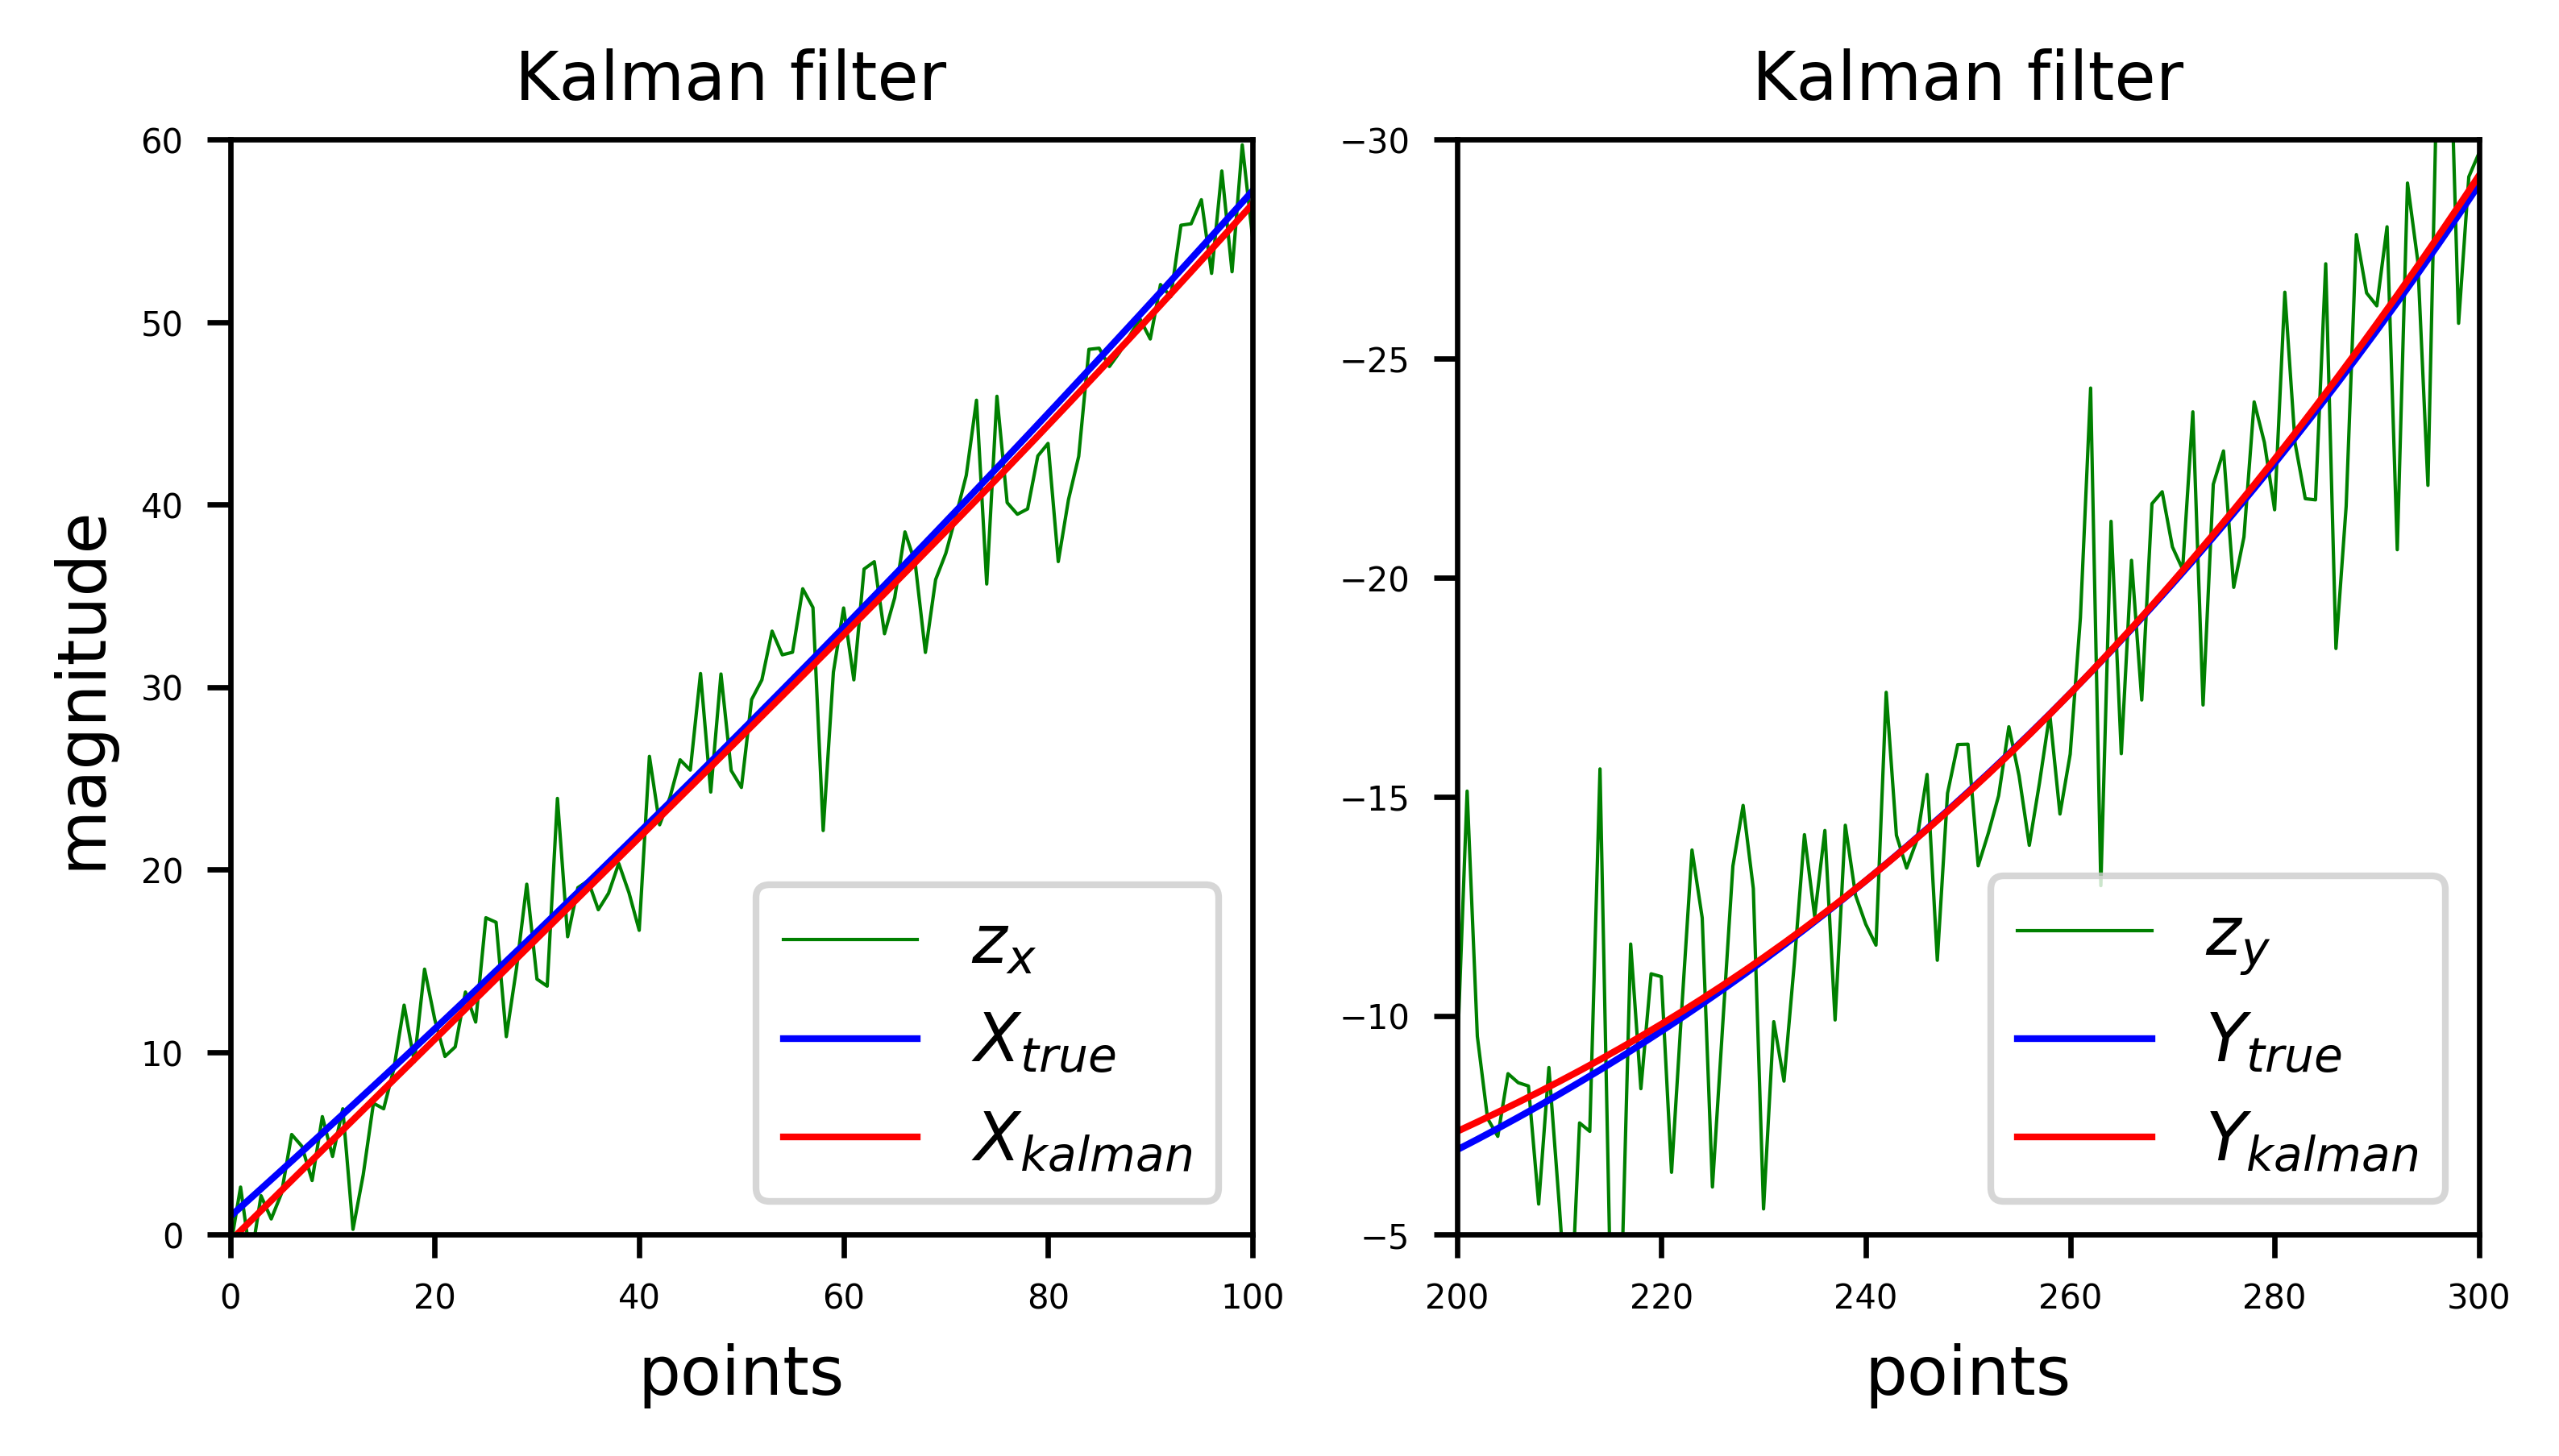

## <center>Now we can extract velocity</center>

In [25]:
V_x_noisy, V_y_noisy = velocity_from_traj(Xs[:,0],t), velocity_from_traj(Xs[:,2],t)
V_gps_noisy = (velocity_from_traj(Xs[:,0], t)**2 + velocity_from_traj(Xs[:,2], t)**2)**0.5

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6, 3), dpi=600)
ax[0].plot(V_x);ax[0].plot(V_x_noisy,label='GPS, noisy');ax[0].set_title("$V_x$");ax[0].set_ylabel("V");
ax[1].plot(V_y,label='GPS');ax[1].plot(V_y_noisy);ax[1].set_title("$V_y$");
ax[2].plot(V_GPS);ax[2].plot(V_gps_noisy);ax[2].plot(V_odom, label='odom');ax[2].set_title("$V$");
for axe in ax:
    axe.set_xlabel('points')
    axe.legend(loc='lower center');

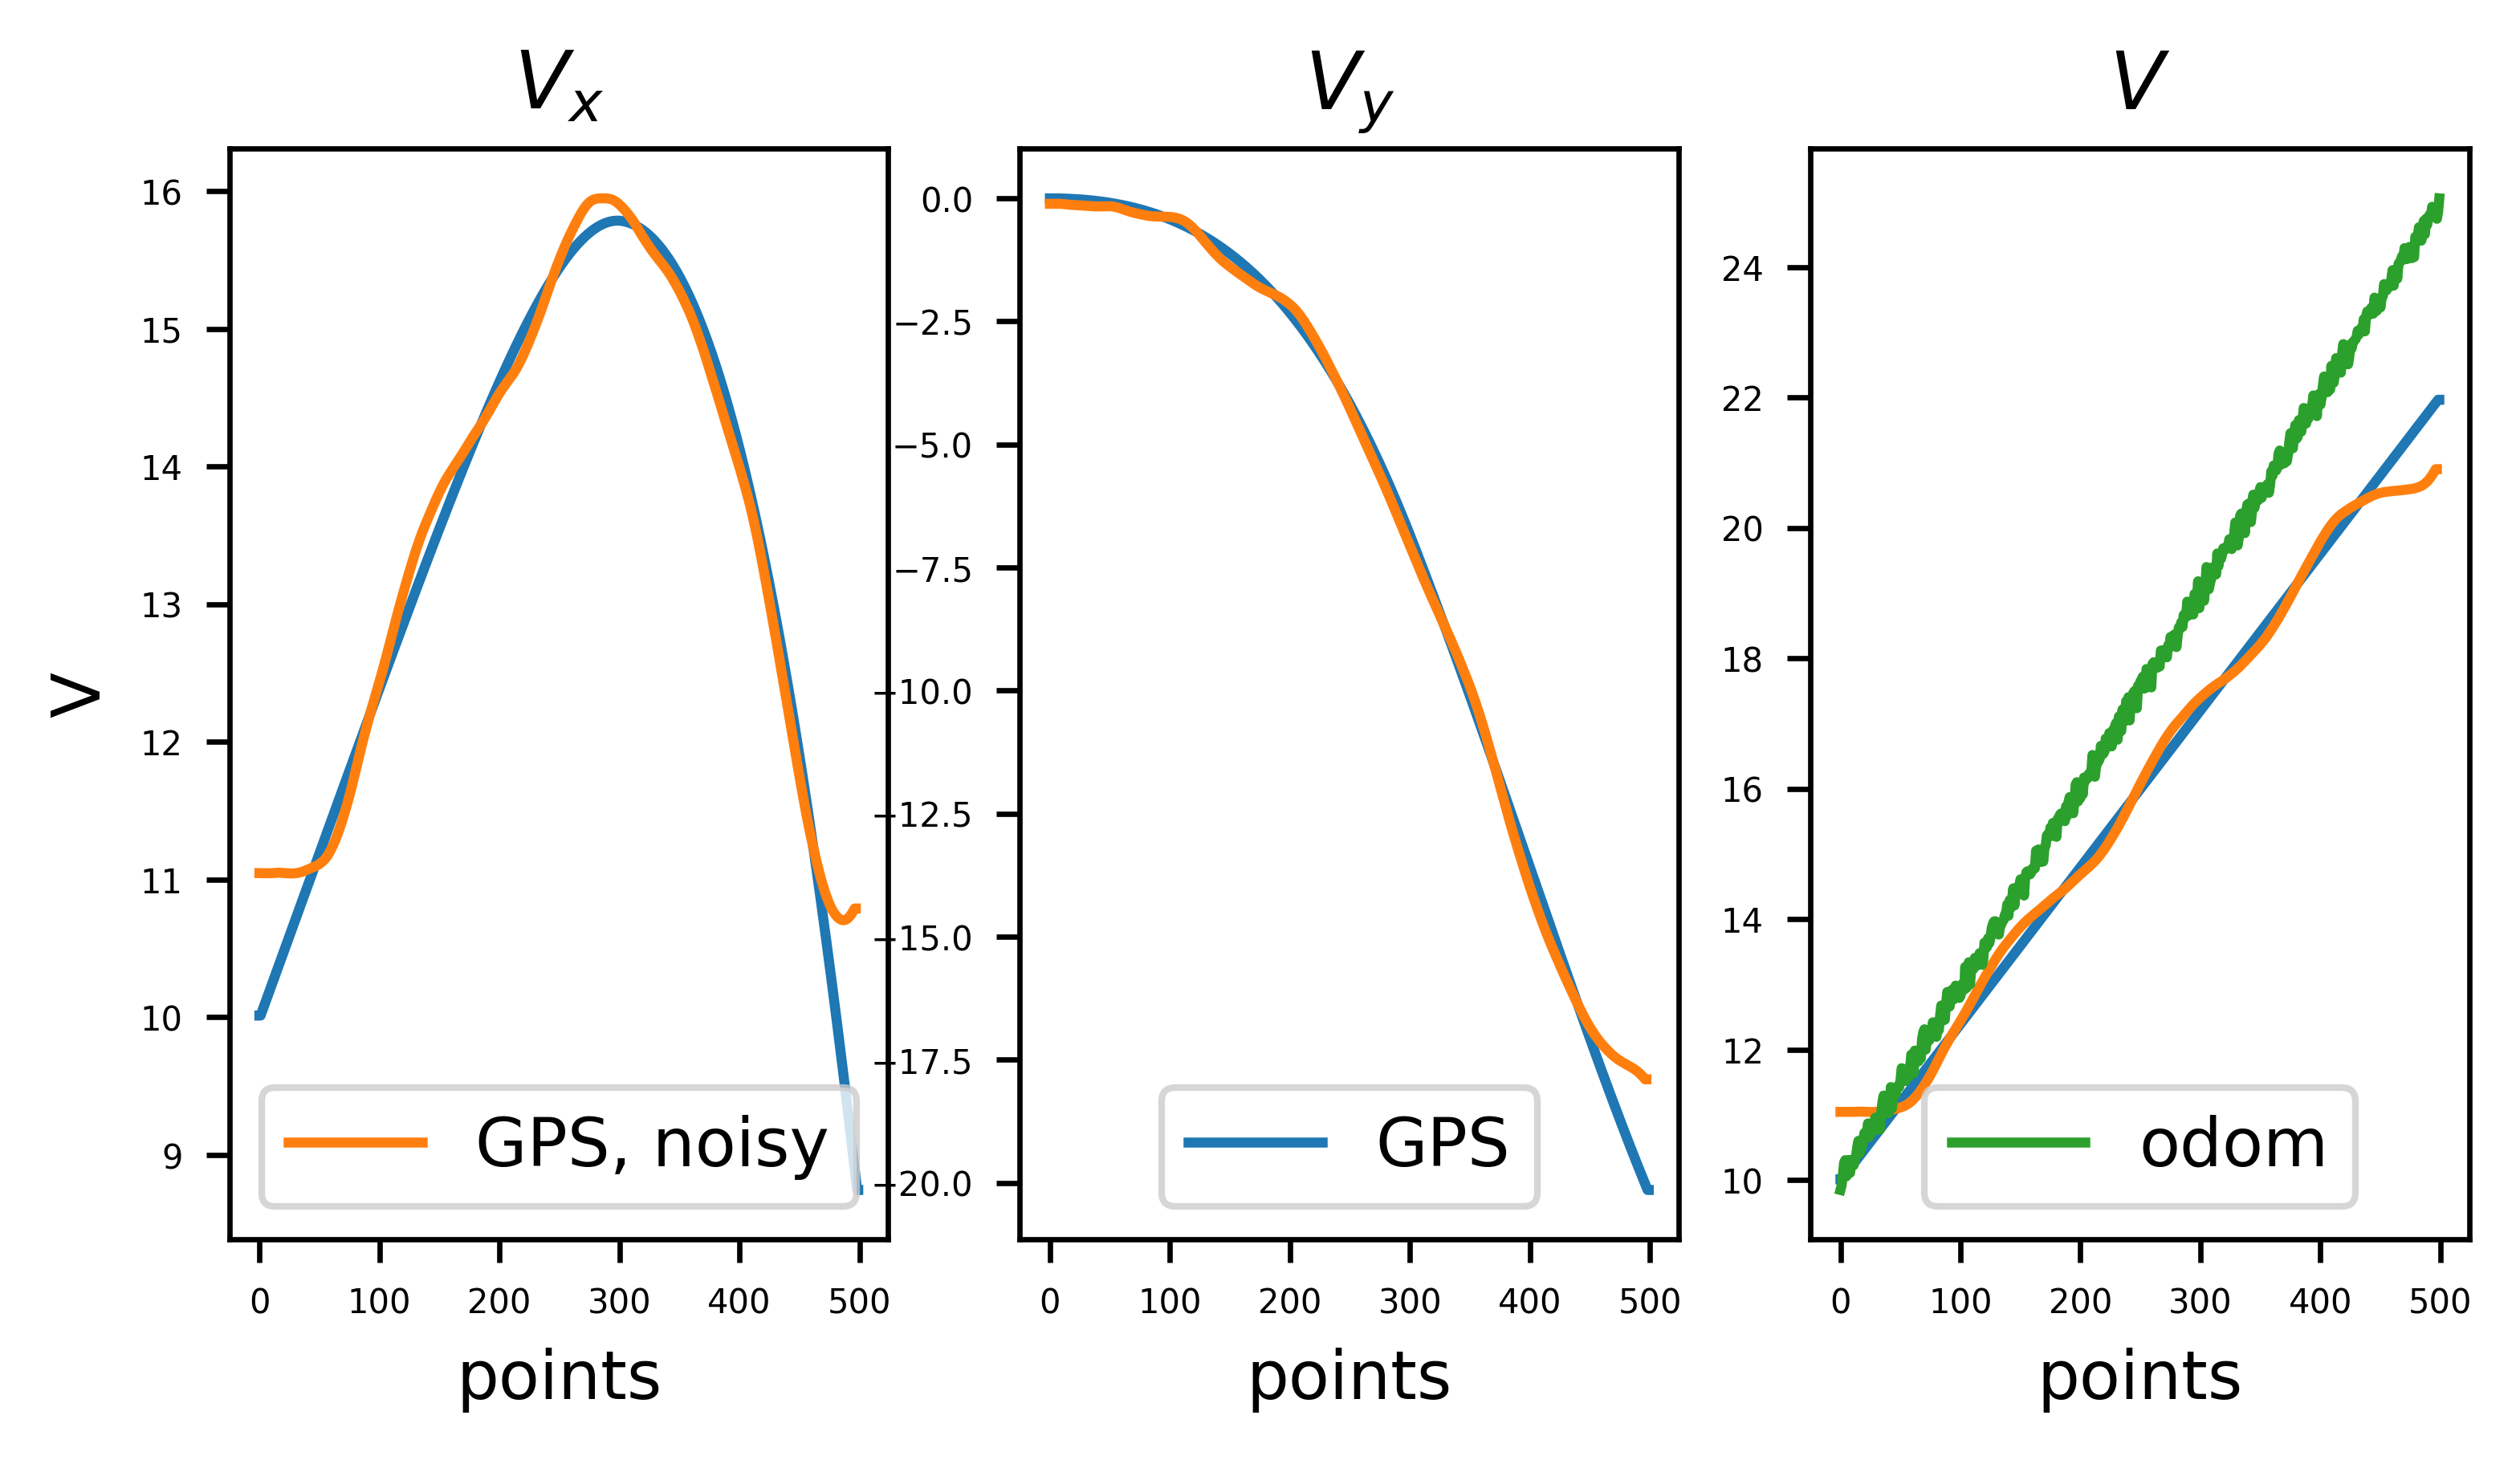

## <center>We got approximate measurements of V. Let's see how they will affect linear regression accuracy</center>

In [27]:
y = V_gps_noisy[:,0]
x = V_odom[2:]

In [28]:
β = LR(y,np.array([np.ones_like(x),x]))
print(β)
rms = RMS(y, np.array([np.ones_like(x),x]), β)
print(rms)

[ 2.75332442  0.75409233]
0.291461948781


$$V_{GPS} = 2.75 + 0.75 \cdot V_{odometry}$$
$$RMS = 0.29$$

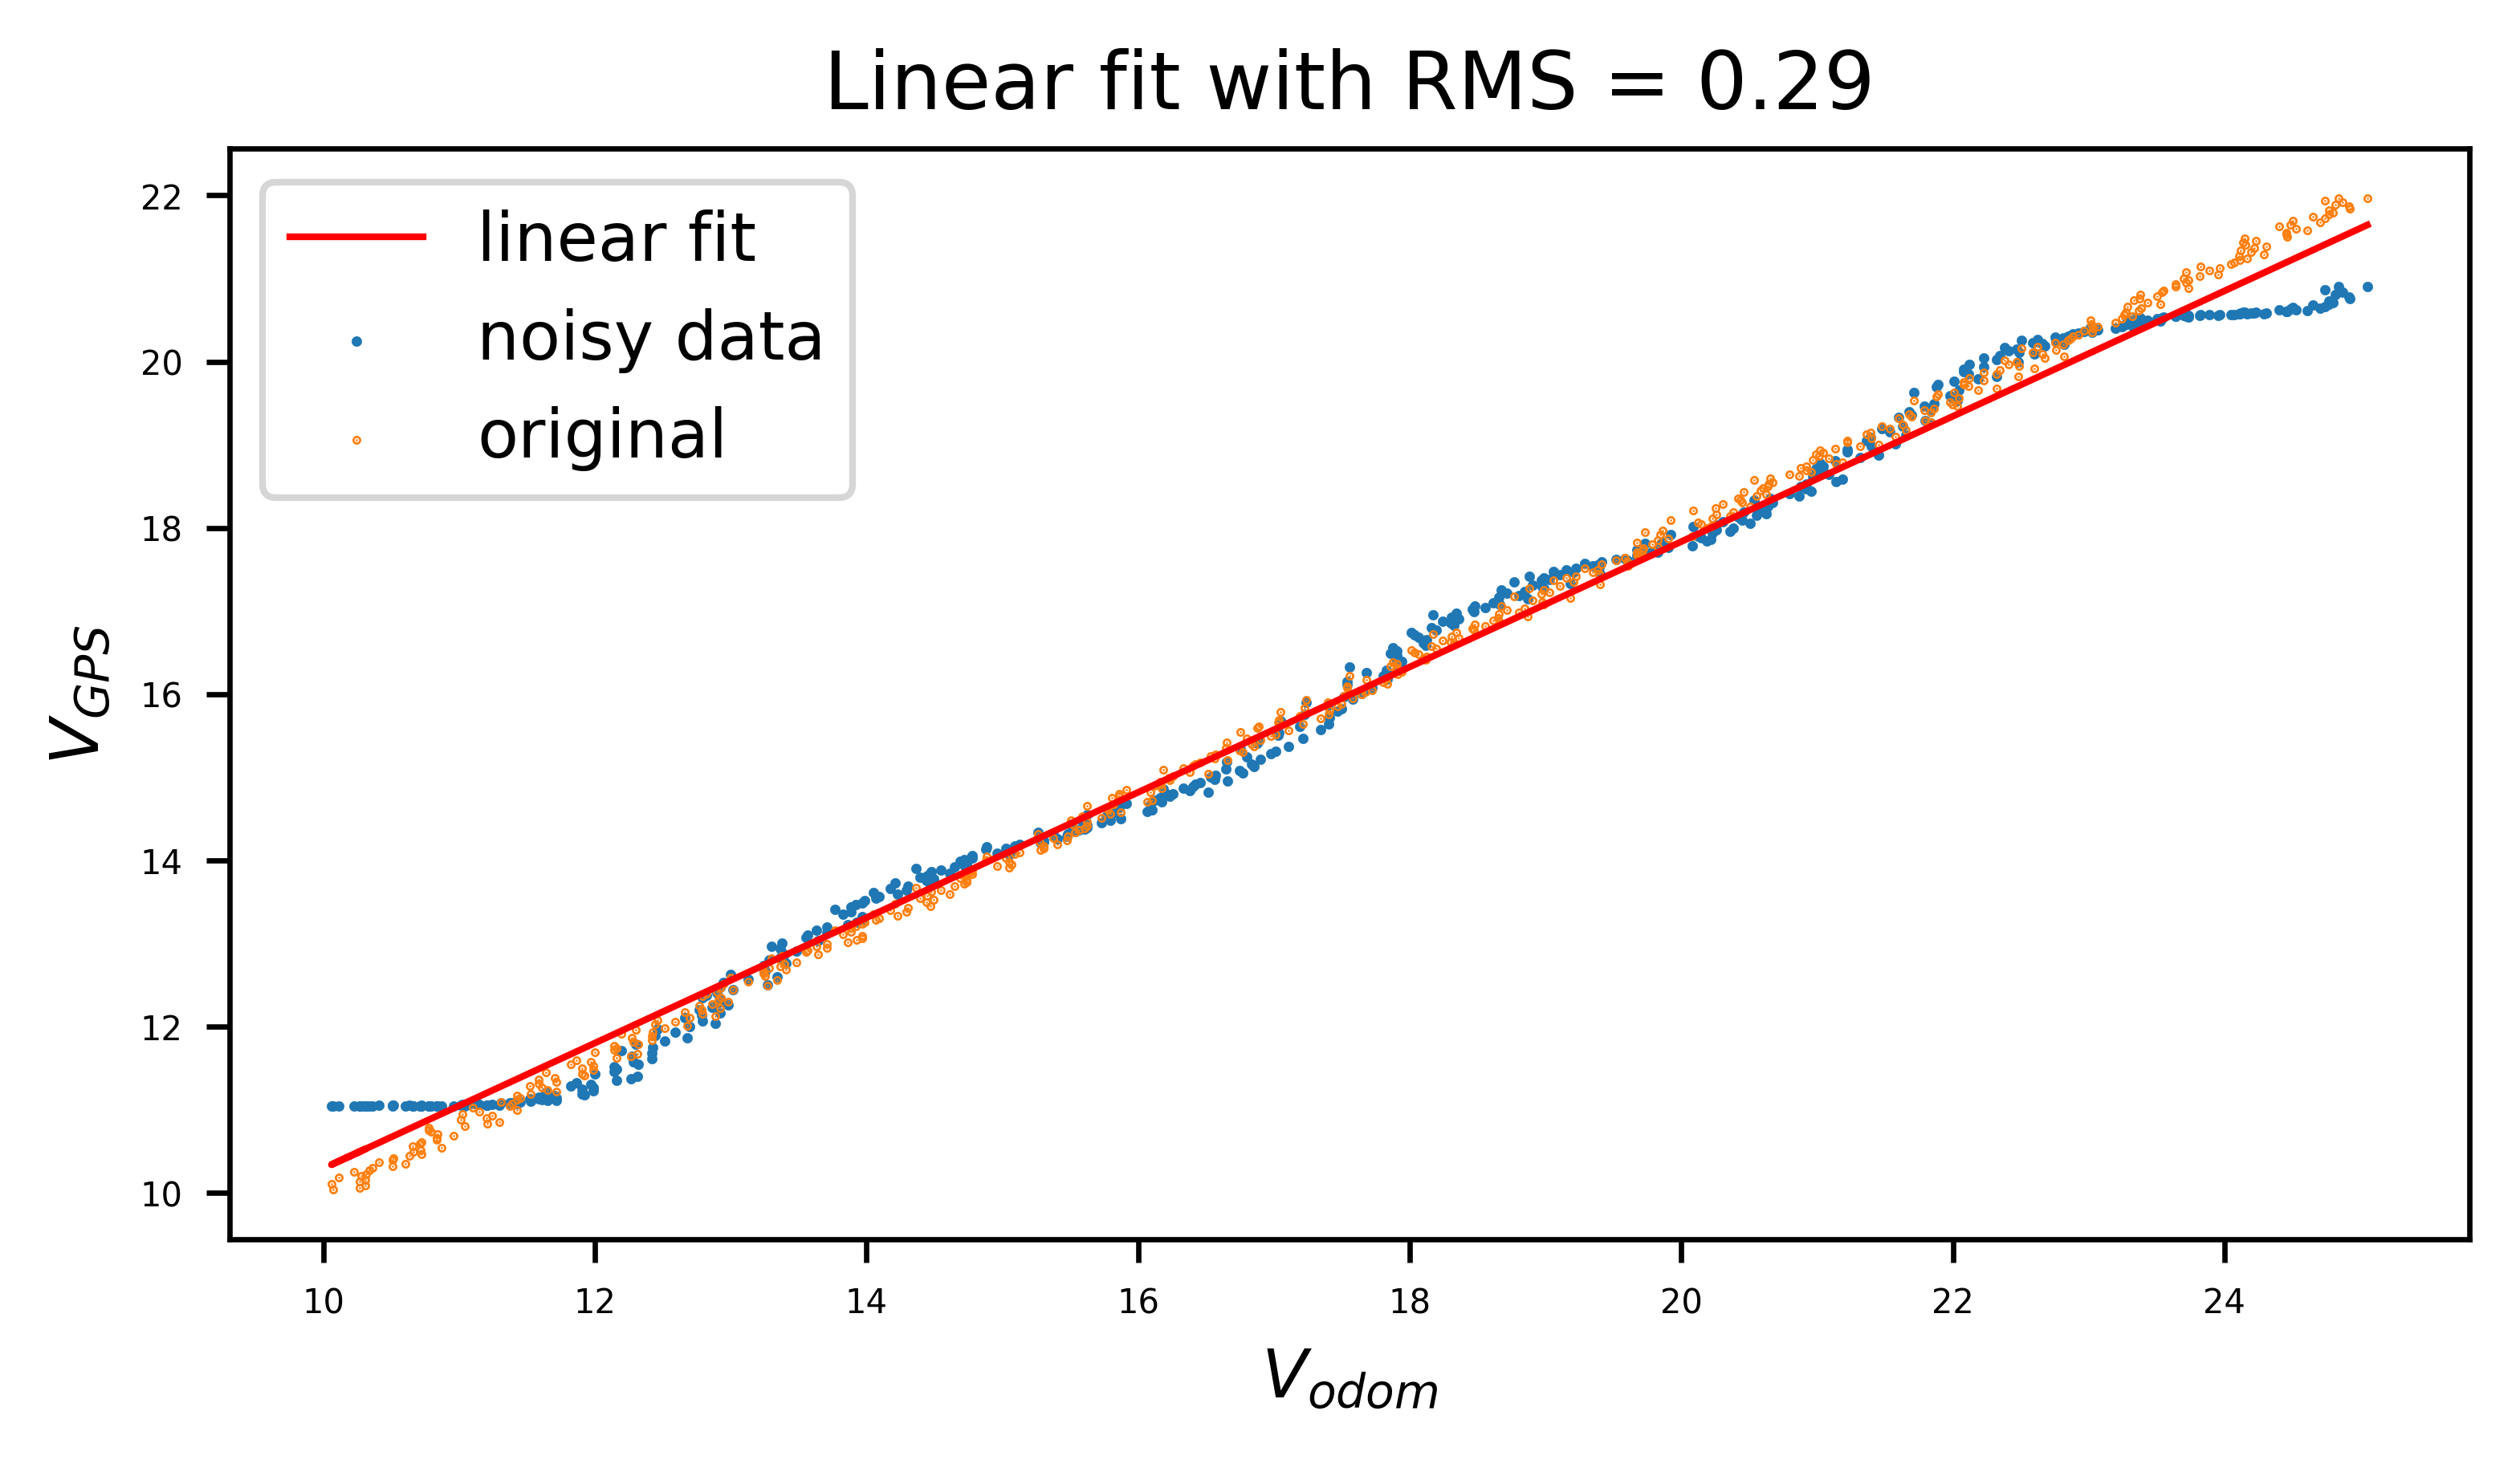

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600)
ax.scatter(x, y, s=0.3,label='noisy data');ax.scatter(x, V_GPS[2:], s=0.1, label='original');
x_line = x;y_line = np.array([np.ones_like(x),x]).transpose().dot(β);
ax.plot(x_line, y_line, linewidth=1, color="r",label='linear fit');ax.set_xlabel("$V_{odom}$");ax.set_ylabel("$V_{GPS}$");ax.legend(loc='best')
ax.set_title("Linear fit with RMS = %.2f" % rms);

## <center>Finally, let's remove ends </center>

In [30]:
interval = range(50, 450)
V_x_noisy2 = V_x_noisy[interval]
V_y_noisy2 = V_y_noisy[interval]
V_gps_noisy2 = V_gps_noisy[interval]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(6, 3), dpi=600)
ax[0].plot(V_x);ax[0].plot(interval,V_x_noisy2,label='GPS, noisy');ax[0].set_title("$V_x$");ax[0].set_ylabel("V");
ax[1].plot(V_y,label='GPS');ax[1].plot(interval,V_y_noisy2);ax[1].set_title("$V_y$");
ax[2].plot(V_GPS);ax[2].plot(interval,V_gps_noisy2);ax[2].plot(V_odom, label='odom');ax[2].set_title("$V$");
for axe in ax:
    axe.set_xlabel('points')
    axe.legend(loc='lower center');

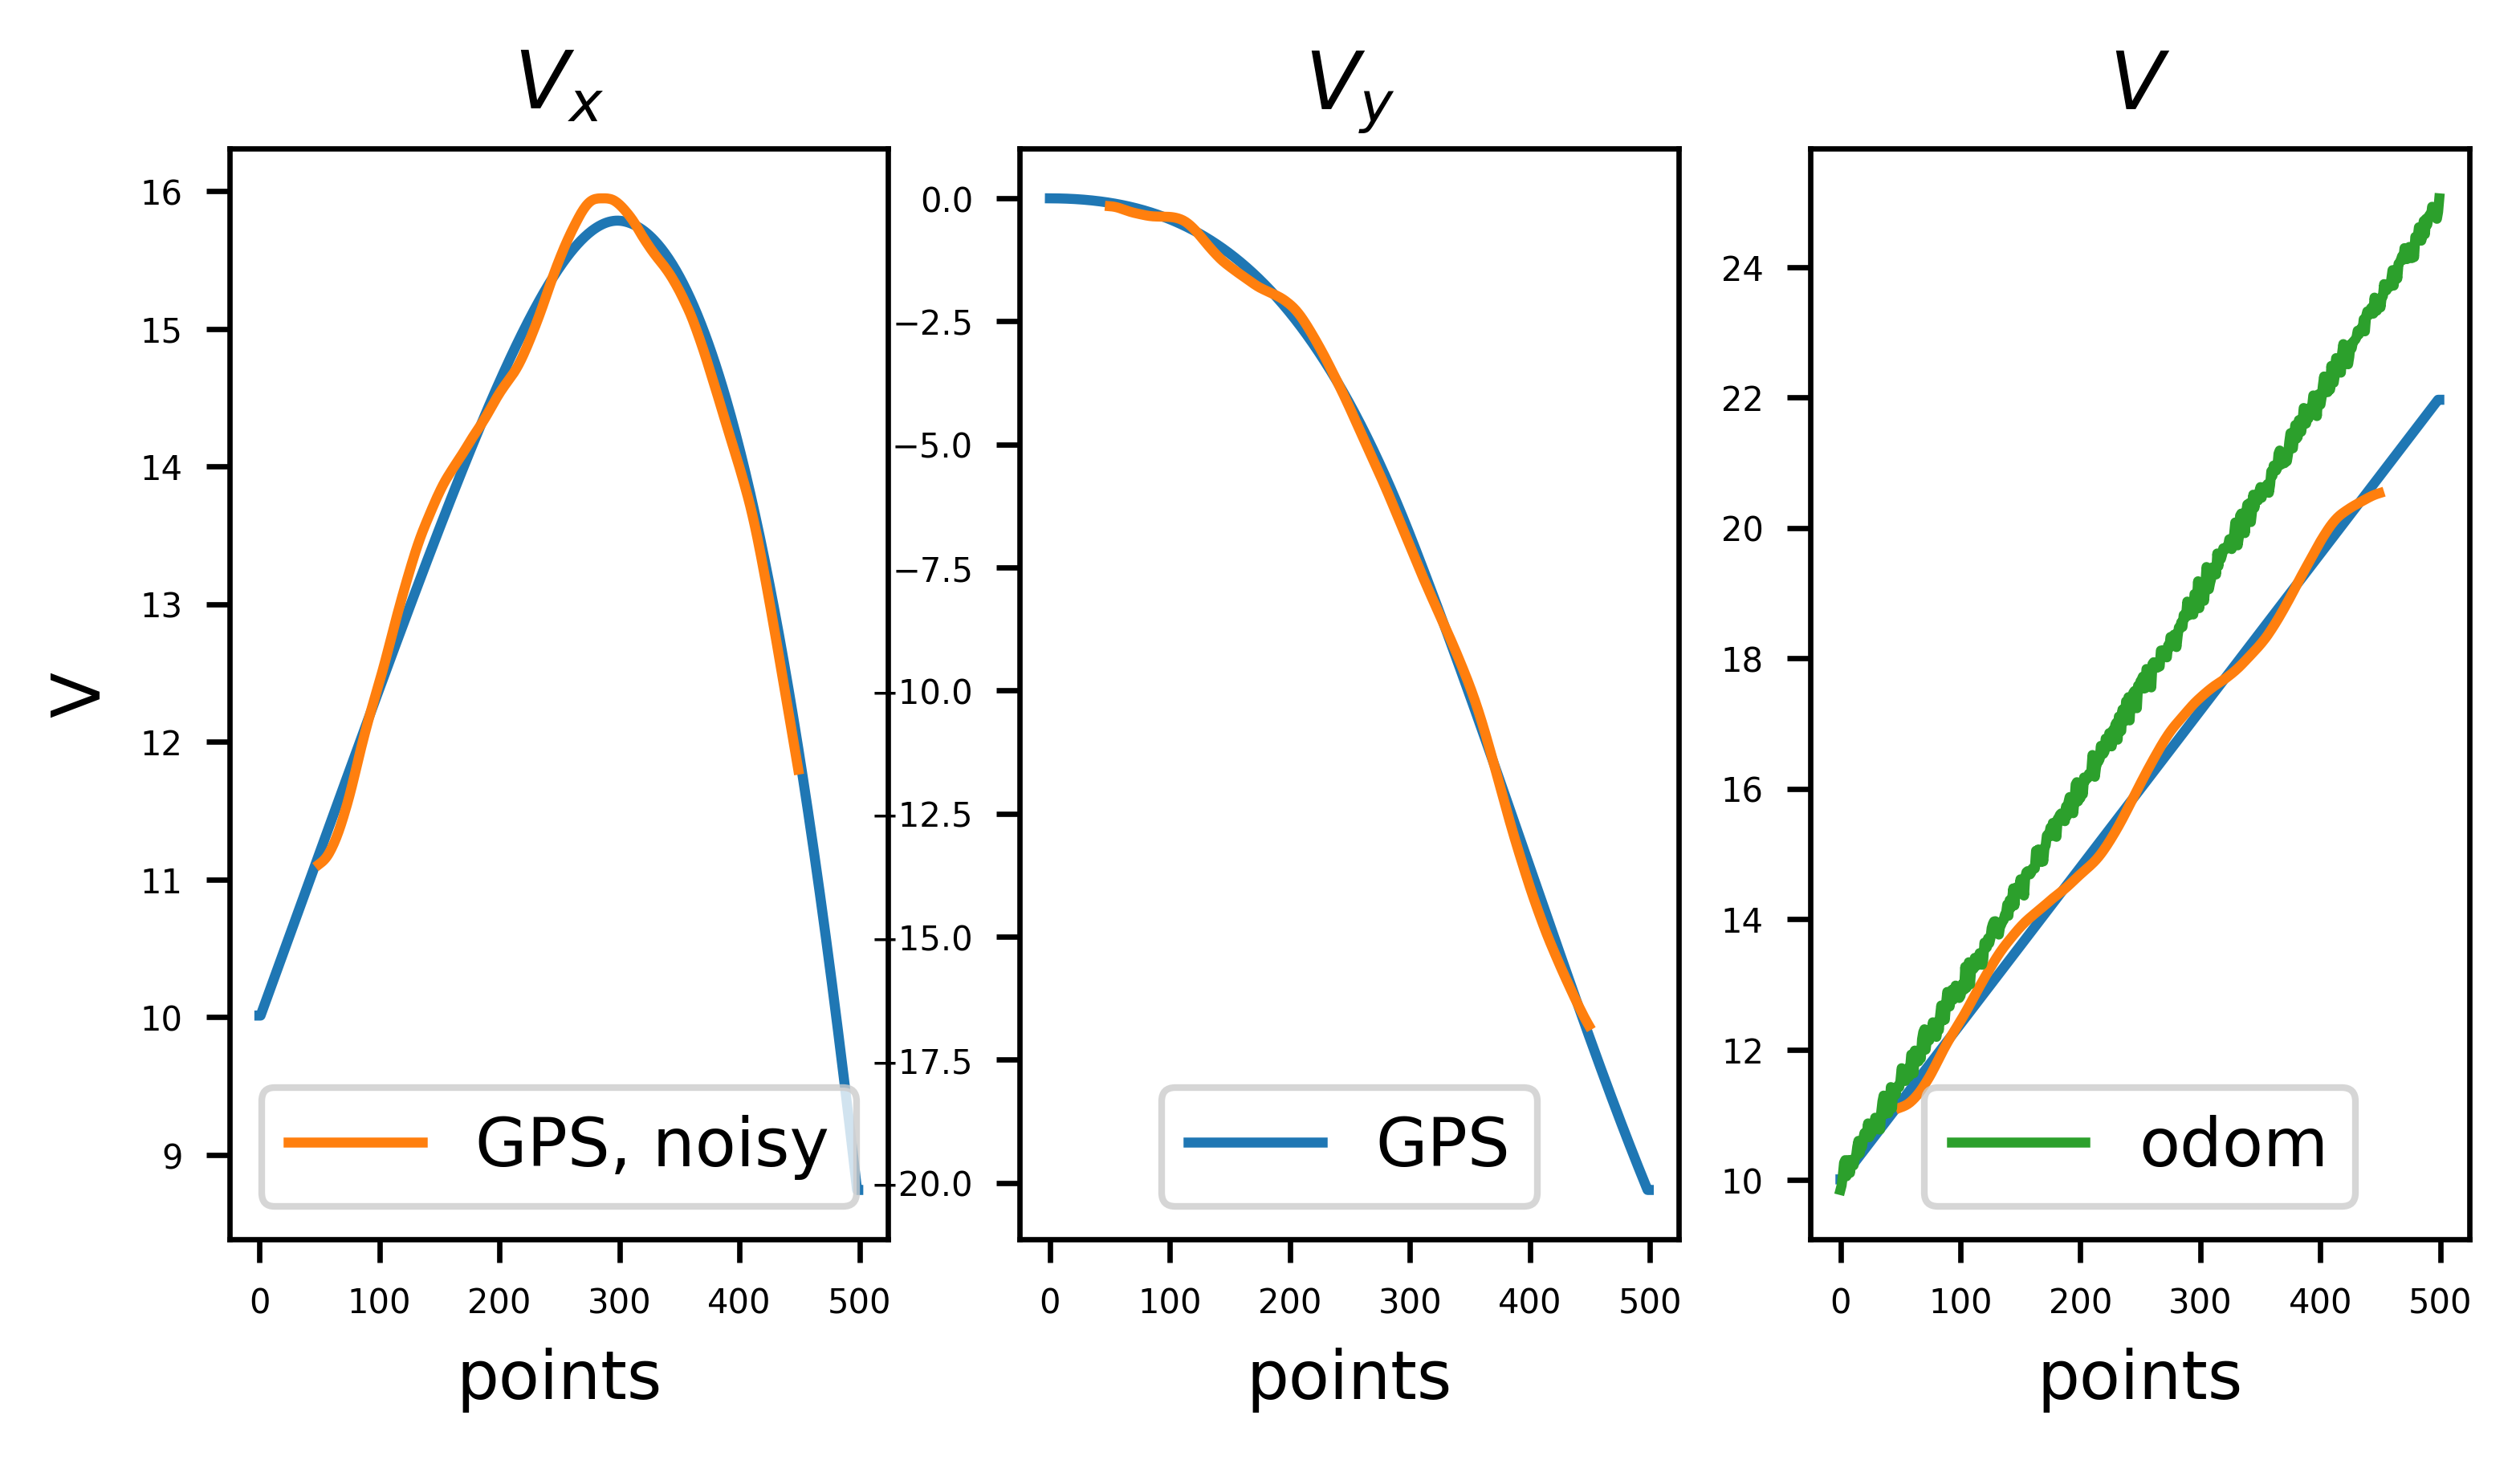

## <center>Results for linear regression are a way closer to GPS without noise</center>

In [32]:
y = V_gps_noisy2[:,0]
x = V_odom[interval]

In [33]:
β = LR(y,np.array([np.ones_like(x),x]))
print(β)
rms = RMS(y, np.array([np.ones_like(x),x]), β)
print(rms)

[ 2.09250348  0.79628892]
0.196604597478


$$V_{GPS} = 2.09 + 0.8 \cdot V_{odometry}$$
$$RMS = 0.2$$

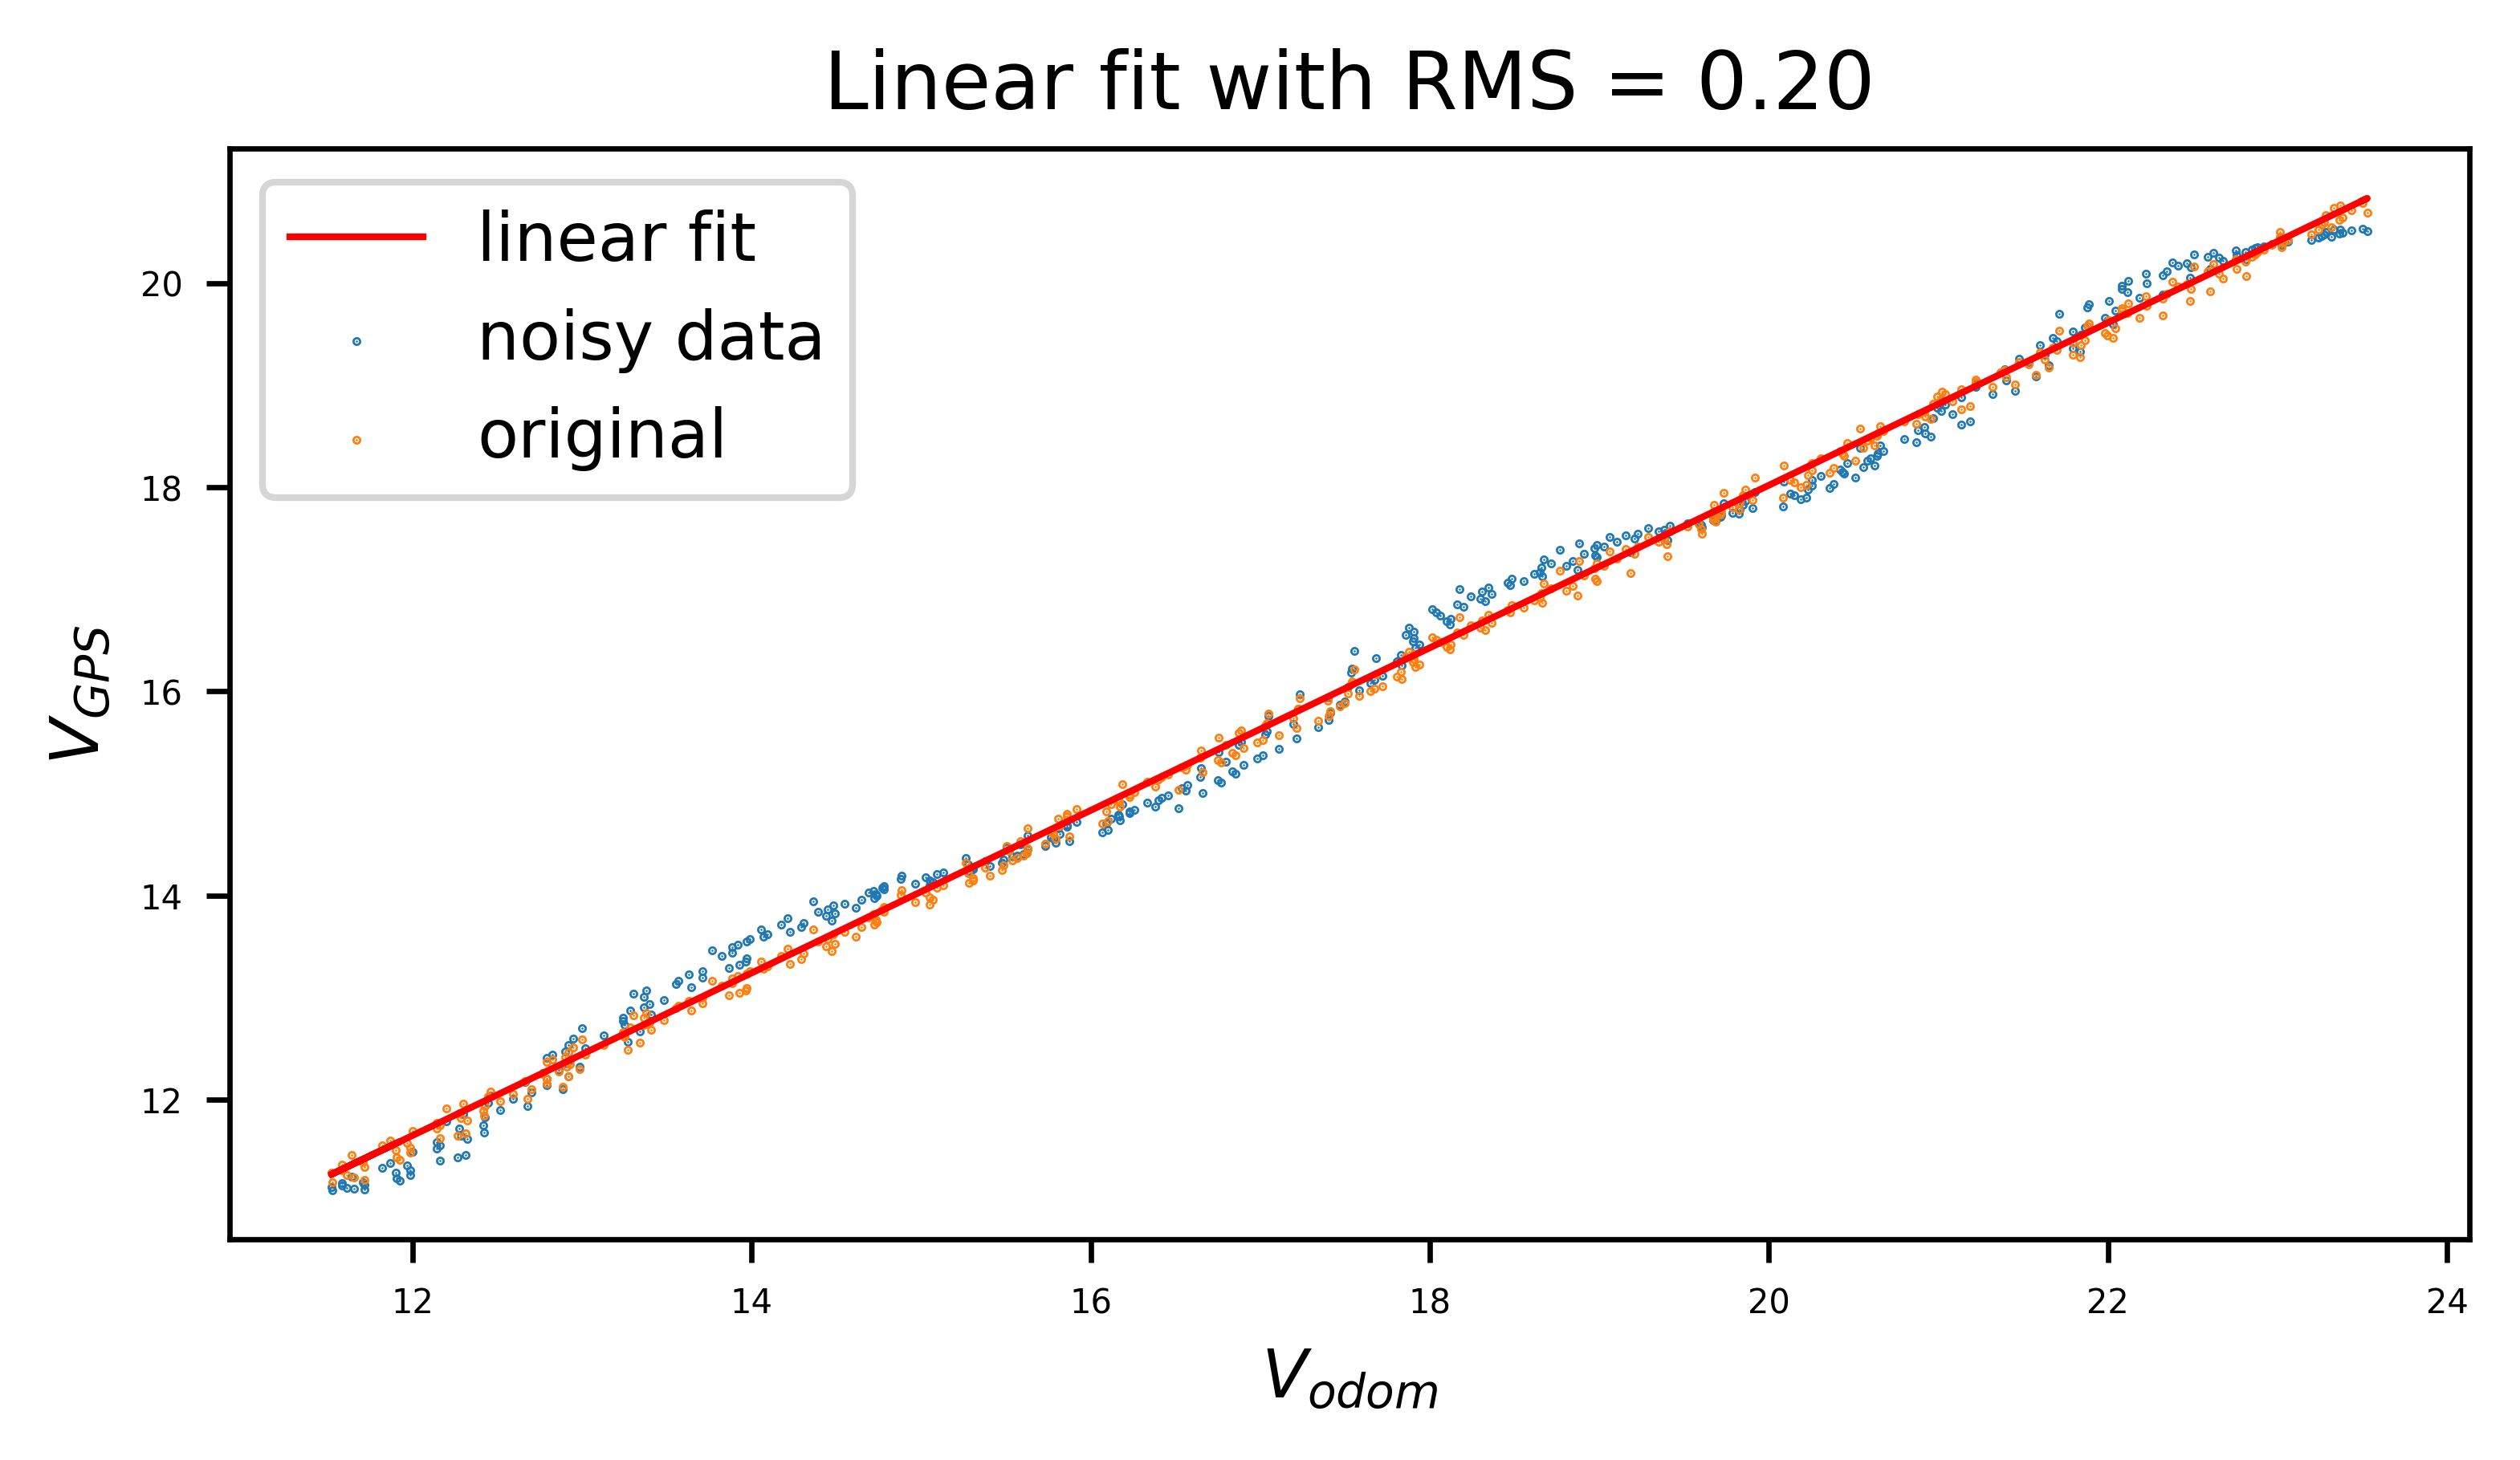

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=600)
ax.scatter(x, y, s=0.1,label='noisy data');ax.scatter(x, V_GPS[interval], s=0.1, label='original')
x_line = x;y_line = np.array([np.ones_like(x),x]).transpose().dot(β);ax.plot(x_line, y_line, linewidth=1, color="r",label='linear fit');ax.set_xlabel("$V_{odom}$");ax.set_ylabel("$V_{GPS}$");ax.legend(loc='best');ax.set_title("Linear fit with RMS = %.2f" % rms);

## <center> Results for different cases</center> 
<h3>
\begin{array}{|l|c|c|c|} \hline
                        & C_0  & C_1 & RMS      \\ \hline
GPS                     & 2.01 & 0.8  & 0.085 \\ \hline
GPS, noisy              & 2.75 & 0.75 & 0.29  \\ \hline
GPS, noisy, cutted~ends & 2.09 & 0.8 & 0.2  \\ \hline
\end{array}
</h3>

# <center> Thank you for listening! </center>